In [39]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
import os
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Define endmembers based on unique classes
endmembers = {
    'ice': np.mean(features_normalized[encoded_labels == le.transform(['ice'])[0]], axis=0),
    'rock': np.mean(features_normalized[encoded_labels == le.transform(['rock'])[0]], axis=0),
    'freshwater': np.mean(features_normalized[encoded_labels == le.transform(['freshwater'])[0]], axis=0),
    'ocean': np.mean(features_normalized[encoded_labels == le.transform(['ocean'])[0]], axis=0),
    'walrus_pure': np.mean(features_normalized[encoded_labels == le.transform(['walrus_pure'])[0]], axis=0),
    'walrus_mixed': np.mean(features_normalized[encoded_labels == le.transform(['walrus_mixed'])[0]], axis=0),
    'walrus_combined': np.mean(features_normalized[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))], axis=0)
}

endmembers_array = np.array(list(endmembers.values()))

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [40]:
# Custom transformer to extract subpixel features
class SubpixelFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, endmembers):
        self.endmembers = endmembers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        n_samples, n_bands = X.shape
        model = LinearRegression(fit_intercept=False)
        model.fit(self.endmembers, np.eye(self.endmembers.shape[0]))
        subpixel_features = model.predict(X)
        return np.hstack([X, subpixel_features])

# Create subpixel feature extractor
subpixel_extractor = SubpixelFeatureExtractor(endmembers_array)

# Transform features to include subpixel features
features_with_subpixel = subpixel_extractor.transform(features_normalized)

# Create DataFrame with original and subpixel features
column_names = [f'Band_{i+1}' for i in range(features.shape[1])]
column_names += [f'Subpixel_{i+1}' for i in range(endmembers_array.shape[0])]

dataset = pd.DataFrame(data=features_with_subpixel, columns=column_names)
dataset['labels'] = labels
dataset['encoded_labels'] = encoded_labels
dataset['image_name'] = image_name

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")


Training Class Distribution:
ocean: 623430
ice: 240184
rock: 74285
freshwater: 32201
walrus_mixed: 637
walrus_pure: 91

Test Class Distribution:
ocean: 155858
ice: 60047
rock: 18571
freshwater: 8050
walrus_mixed: 159
walrus_pure: 22


In [41]:
# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)

# Visualize class distribution as a table and boxplot
def visualize_class_distribution(df):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    class_dist_df = pd.DataFrame({'Class': class_names, 'Count': class_counts.values})

    print("\nClass Distribution Table:")
    print(class_dist_df)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='labels', y='Count', data=class_dist_df)
    plt.title("Class Distribution")
    plt.show()

visualize_class_distribution(train_df)
visualize_class_distribution(test_df)


Test Dataset Island Distribution:
buch: 110499
tor: 54751
pal: 34004
sars: 30111
moff: 13342

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23538
Image: buch_20230720_image.tif, Pixels: 37178
Image: buch_20230731_image.tif, Pixels: 34901
Image: buch_20230923_image.tif, Pixels: 14882
Image: moff_20230717_image.tif, Pixels: 13342
Image: pal_20230714_image.tif, Pixels: 12664
Image: pal_20230720_image.tif, Pixels: 5703
Image: pal_20230726_image.tif, Pixels: 15637
Image: sars_20230714_image.tif, Pixels: 14837
Image: sars_20230803_image.tif, Pixels: 15274
Image: tor_20230801_image.tif, Pixels: 14931
Image: tor_20230824_image.tif, Pixels: 12079
Image: tor_20230901_image.tif, Pixels: 16777
Image: tor_20230902_image.tif, Pixels: 10964

Class Distribution Table:
          Class   Count
0         ocean  623430
1           ice  240184
2          rock   74285
3    freshwater   32201
4  walrus_mixed     637
5   walrus_pure      91


ValueError: Could not interpret value `labels` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [42]:
# Train the Random Forest model without SMOTE
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_allislands0207_with_subpixel.joblib"
joblib.dump(model, model_filename)

['RF_allislands0207_with_subpixel.joblib']

Accuracy: 0.9872191572554562
Precision: 0.9871606201592484
Recall: 0.9872191572554562
F1 Score: 0.9869774377402613
Cohen's Kappa: 0.9753685705052078

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.90      0.86      0.88      8050
         ice       0.97      0.99      0.98     60047
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.96      0.97     18571
walrus_mixed       1.00      0.23      0.37       159
 walrus_pure       0.90      0.41      0.56        22

    accuracy                           0.99    242707
   macro avg       0.96      0.74      0.79    242707
weighted avg       0.99      0.99      0.99    242707


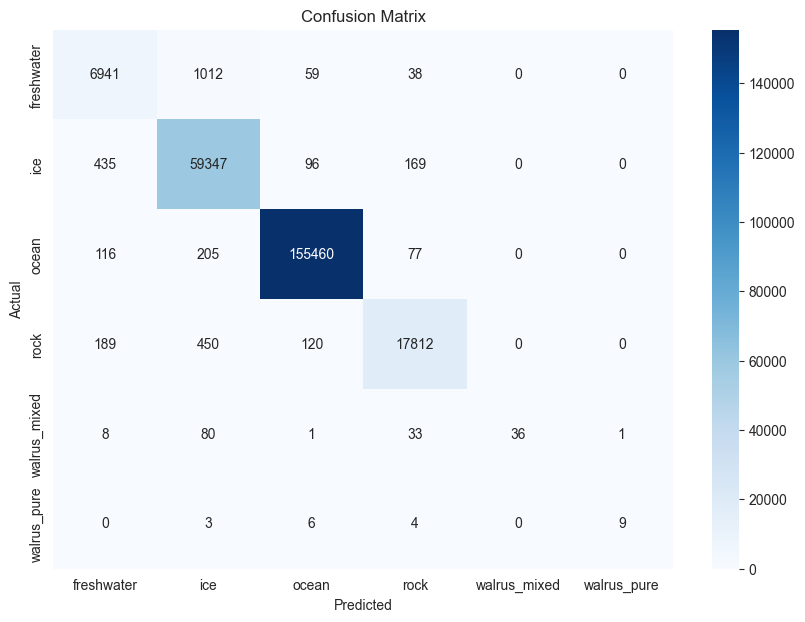

ValueError: multiclass format is not supported

In [43]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Labels present in buch_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


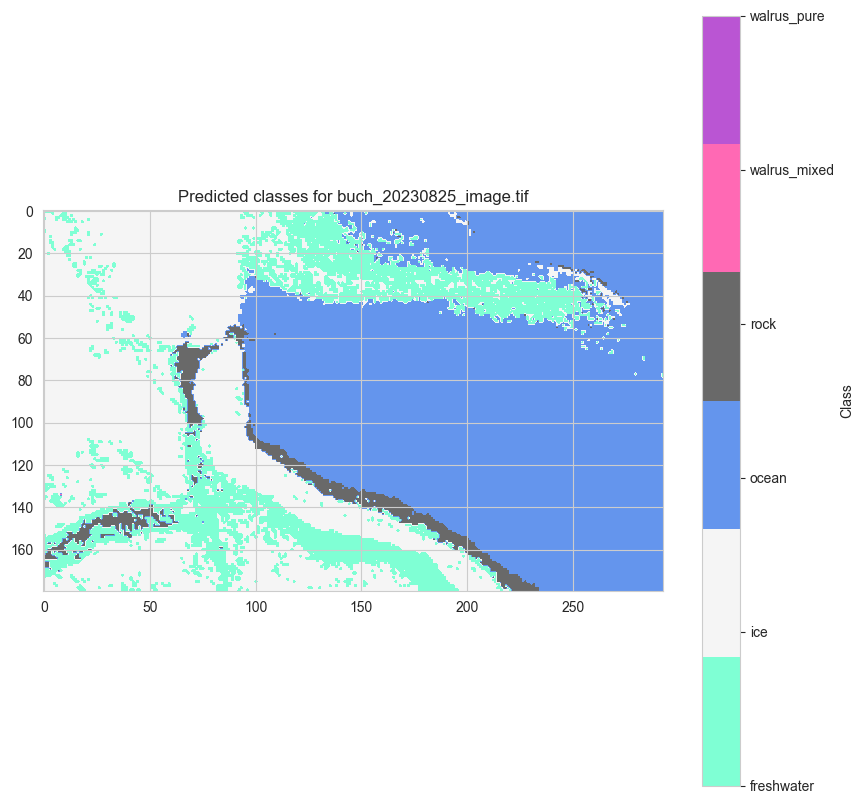

Labels present in buch_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


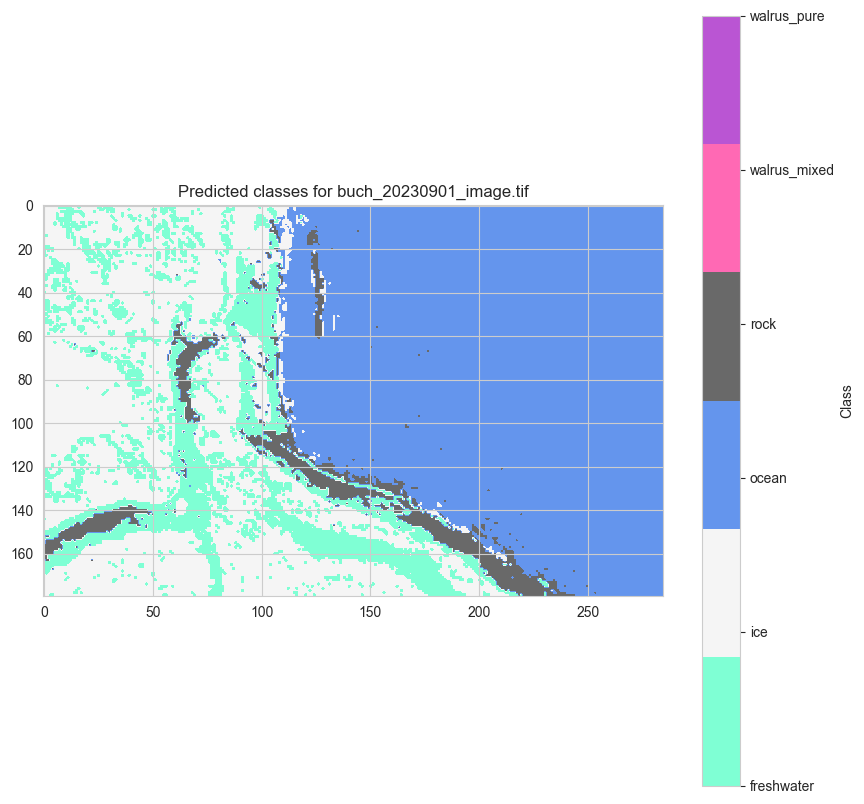

Labels present in pal_20230817_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


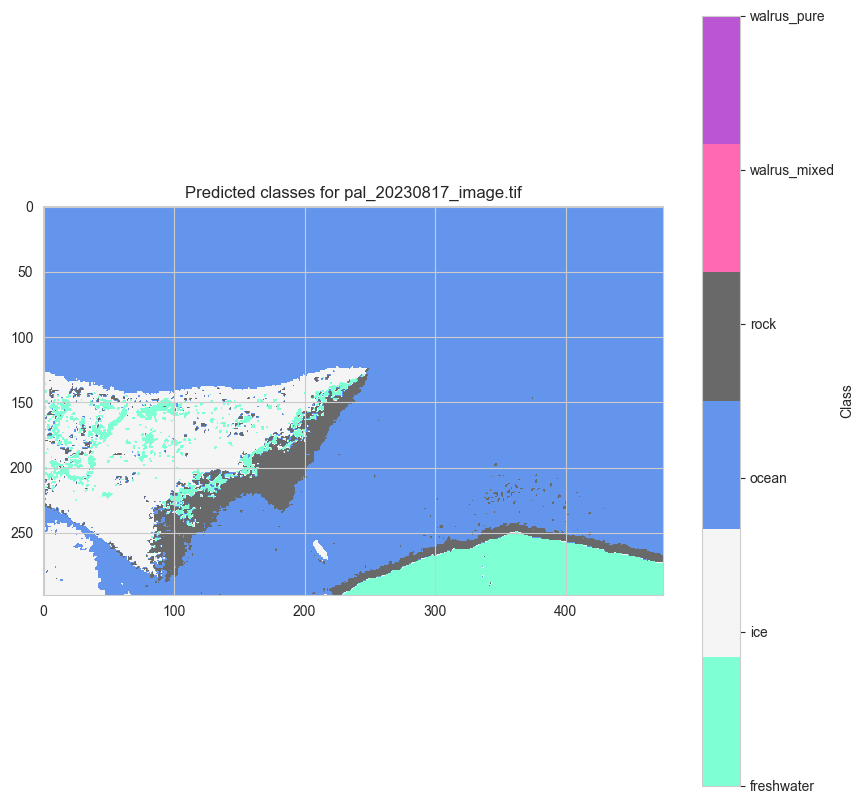

Labels present in pal_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


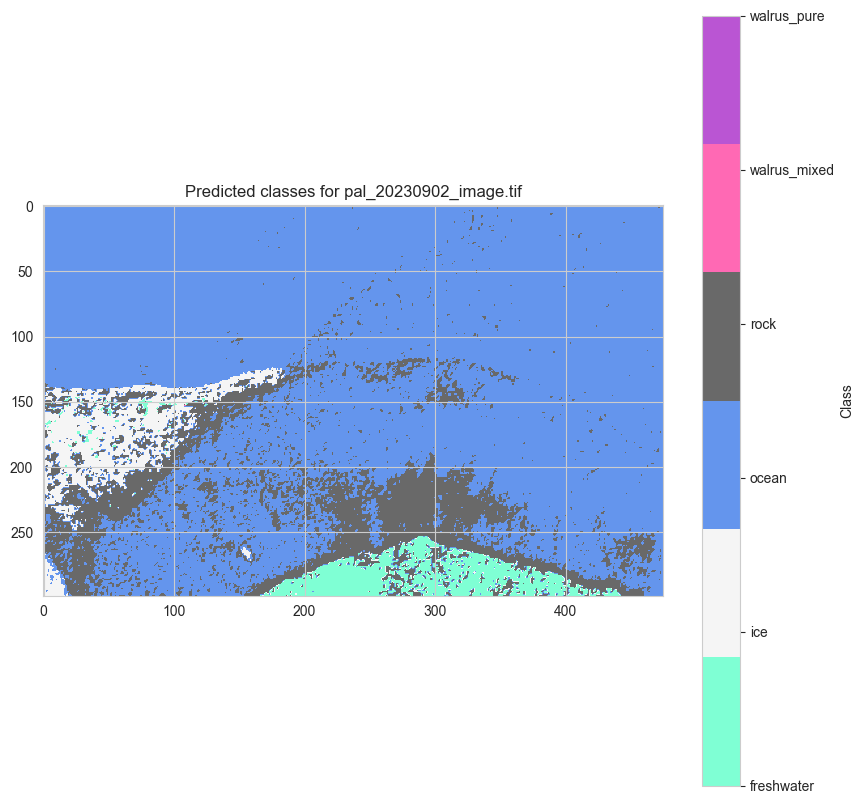

Labels present in sars_20230719_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


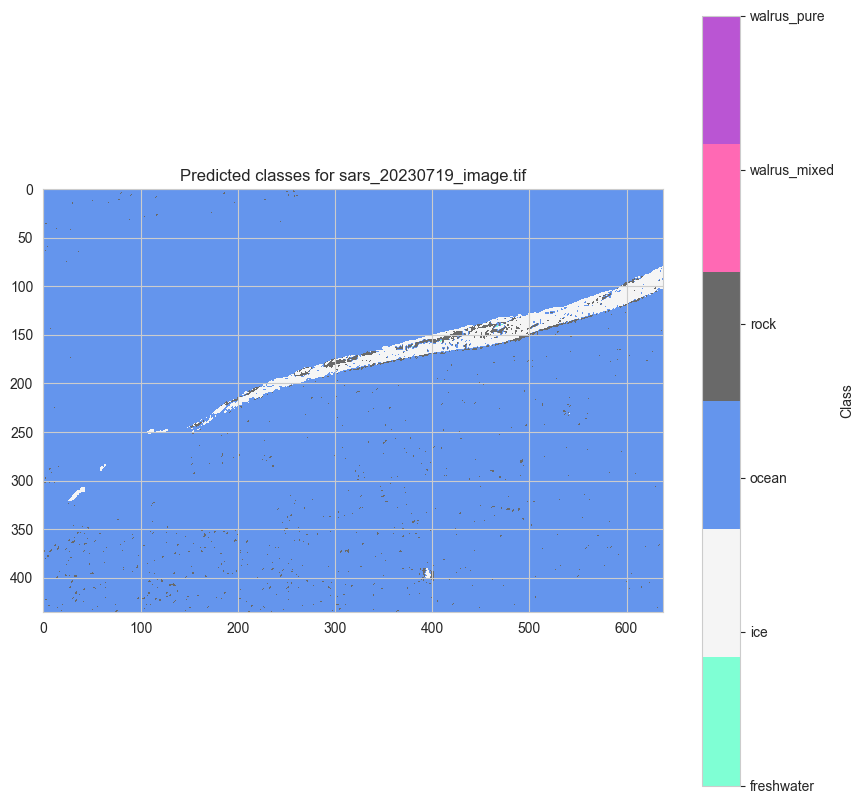

Labels present in sars_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


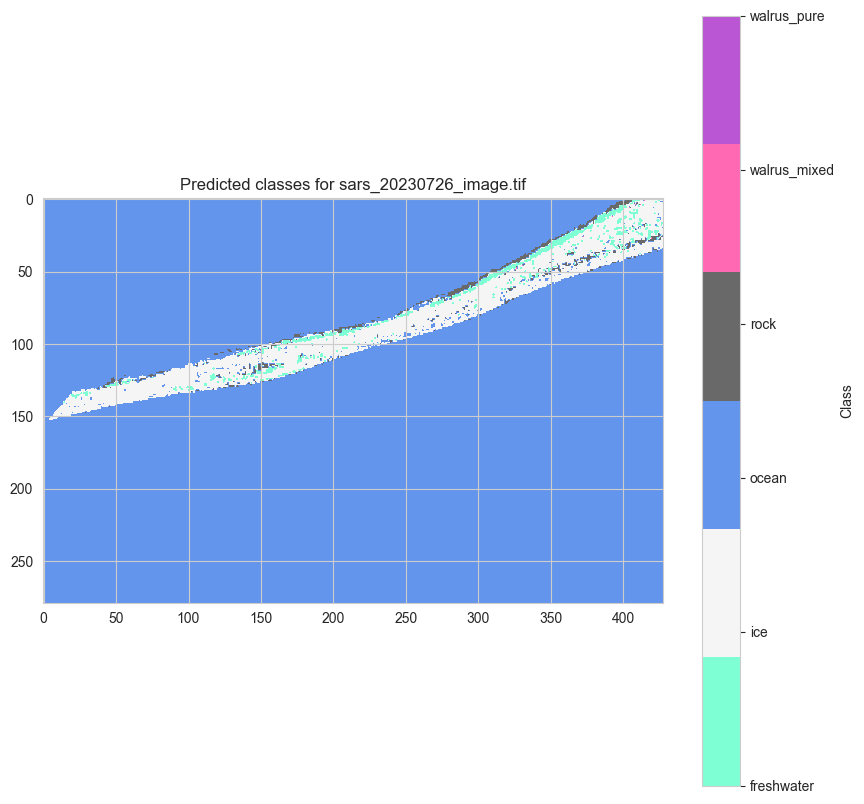

Labels present in sars_20230808_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


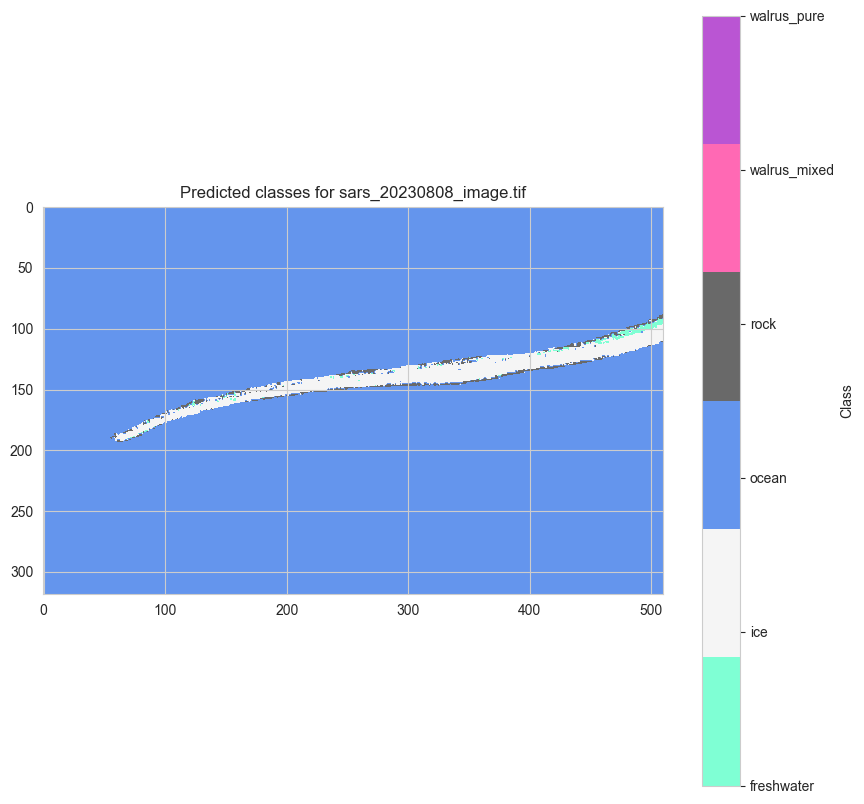

Labels present in tor_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


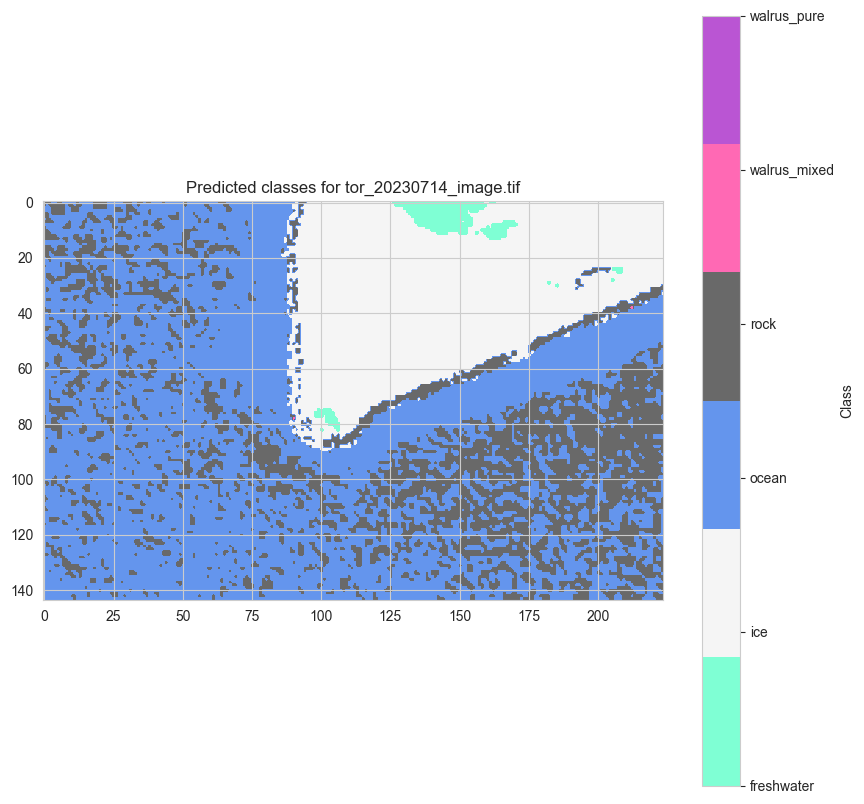

Labels present in tor_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


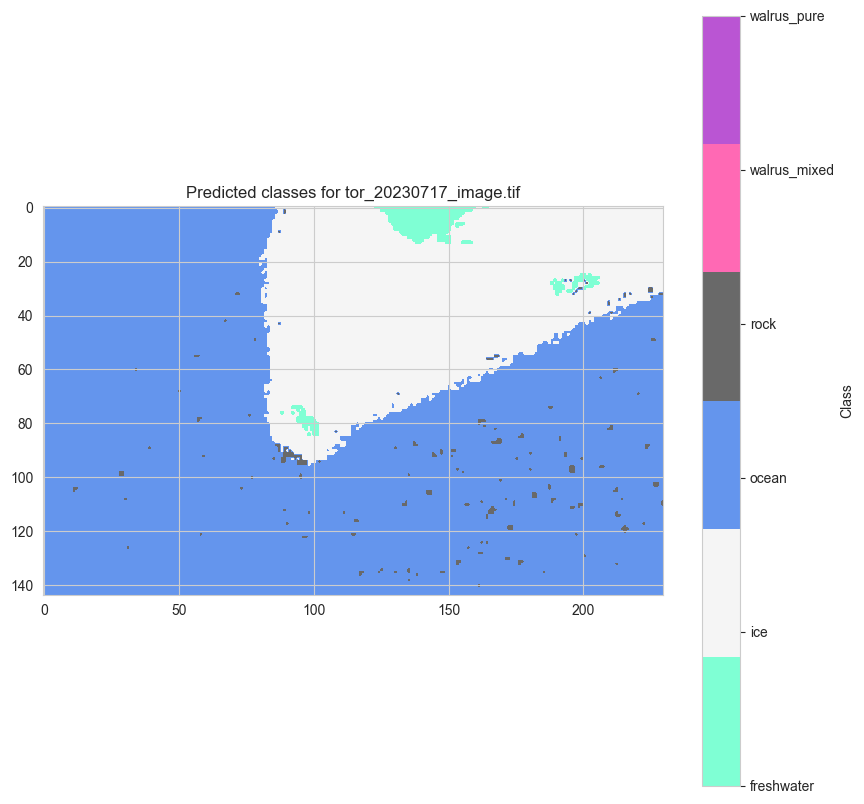

Labels present in tor_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


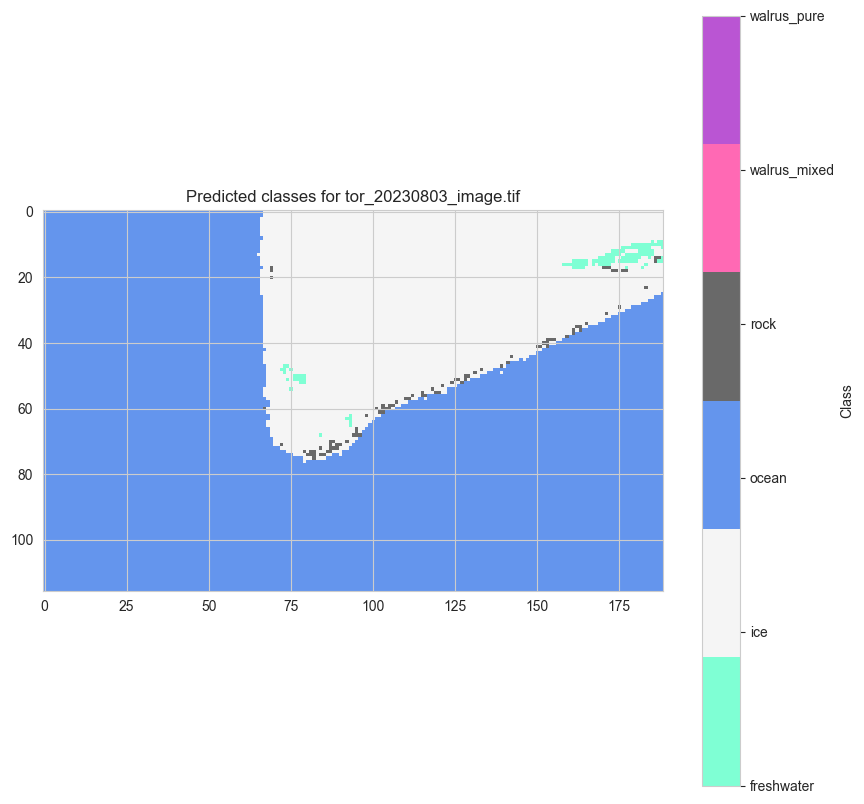

Labels present in tor_20230825_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


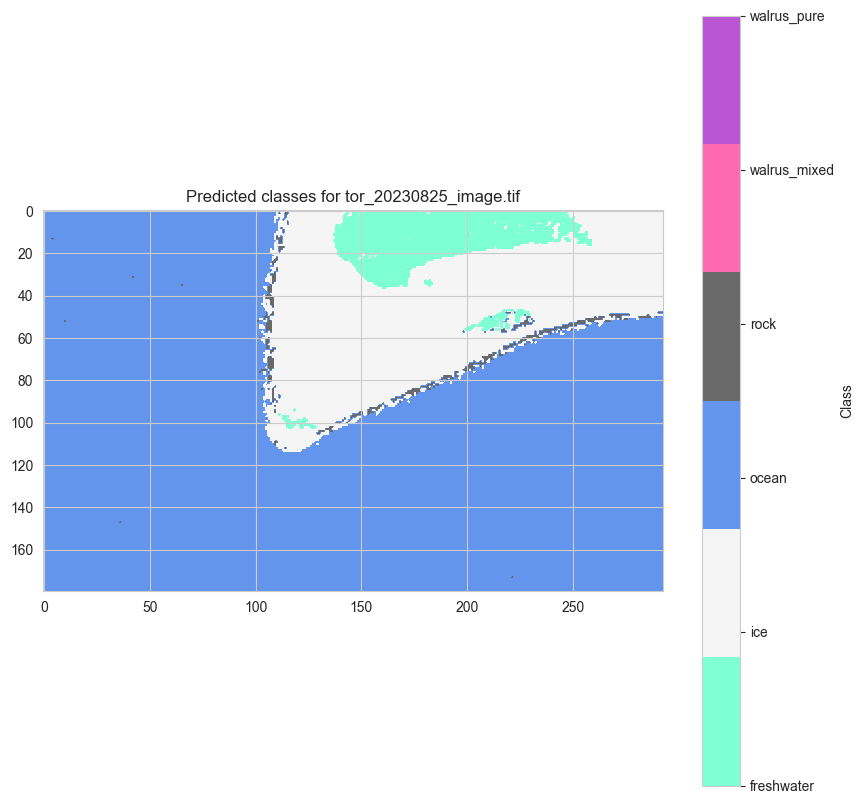

Labels present in tor_20230910_image.tif: ['freshwater', 'ice', 'ocean', 'rock']


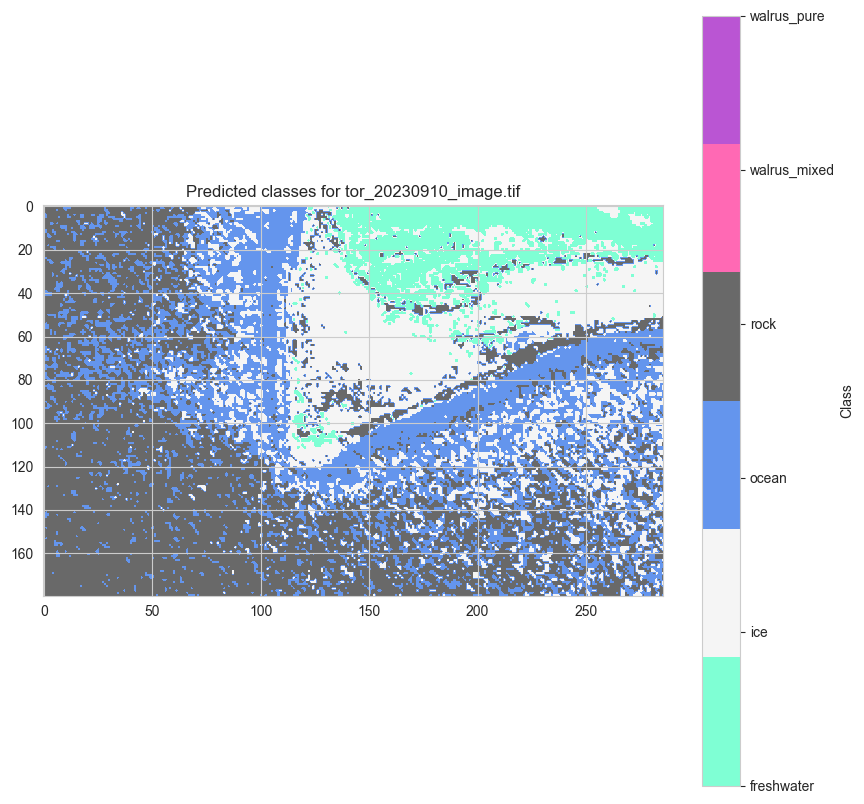

In [44]:
# Function to predict classes for a given image
def predict_image(image_path, model, subpixel_extractor):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        
        # Normalize the image data
        image_reshaped_normalized = scaler.transform(image_reshaped)
        
        # Extract subpixel features
        image_with_subpixel = subpixel_extractor.transform(image_reshaped_normalized)
        
        # Predict with Random Forest
        predictions_rf = model.predict(image_with_subpixel)
        
        return predictions_rf.reshape((src.height, src.width))

predicted_images = {}

for image_path in unlabeled_image_paths:
    predicted_images[image_path] = predict_image(image_path, model, subpixel_extractor)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'walrus_combined': 'orchid'
}

# Create a fixed color map based on all possible labels
cmap = plt.cm.colors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [ ]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model, subpixel_extractor)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif

Training Class Distribution:
ocean: 623430
ice: 240184
rock: 74285
freshwater: 32201
walrus_mixed: 637
walrus_pure: 91

Test Class Distribution:
ocean: 155858
ice: 60047
rock: 18571
freshwater: 8050
walrus_mixed: 159
walrus_pure: 22

Test Dataset Island Distribution:
buch: 110499
tor: 54751
pal: 34004
sars: 30111
moff: 13342

Test Dataset Image Names and Pixel Counts:
Image: buch_20230714_image.tif, Pixels: 23538
Image: buch_20230720_image.tif, Pixels: 37178
Image: buch_20230731_image.tif, Pixels: 34901
Image: buch_20230923_image.tif, Pixels: 14882
Image: moff_20230717_image.tif, Pixels: 13342
Image: pal_20230714_image.tif, Pixels: 12664
Image: pal_20230720_image.tif, Pixels: 5703
Image: pal_20230726_image.tif, Pixels: 15637
Image: sars_20230714_image.tif, Pixels: 14837
Image: sars_20230803_image.tif, Pixels: 15274
Image: tor_20230801_image.tif, Pixels: 14931
Image: 

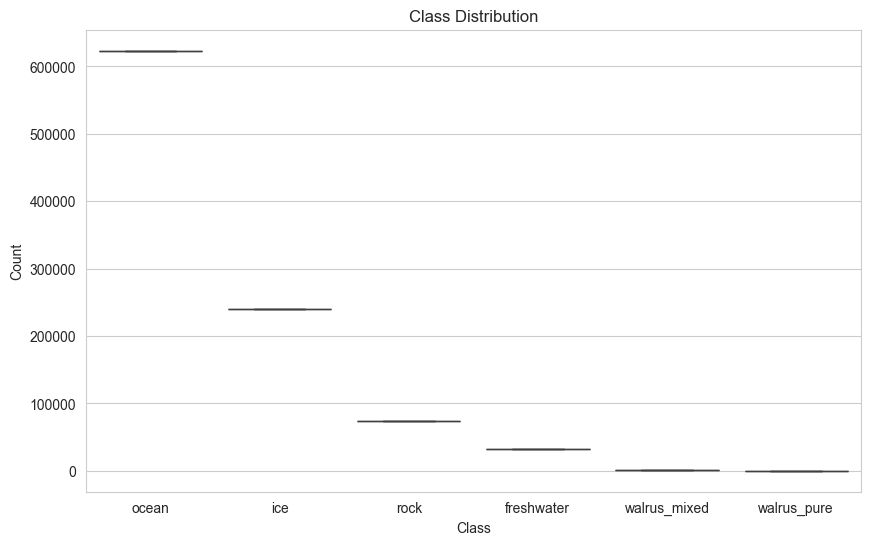


Class Distribution Table:
          Class   Count
0         ocean  155858
1           ice   60047
2          rock   18571
3    freshwater    8050
4  walrus_mixed     159
5   walrus_pure      22


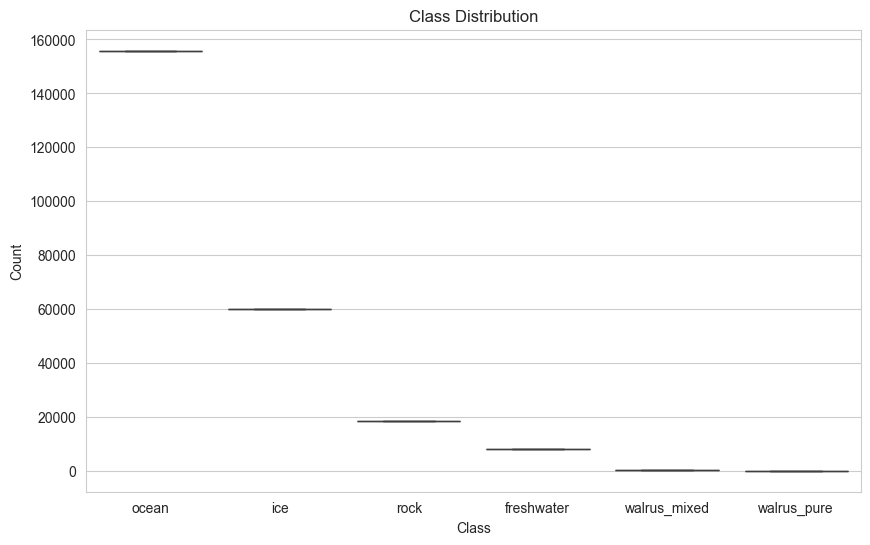

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glob
import os
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values

# Calculate and print the number of pixels for each class in the training and test datasets
def print_class_distribution(df, name):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Calculate class distributions
print_class_distribution(train_df, "Training")
print_class_distribution(test_df, "Test")

# Calculate and print the number of pixels from each island in the test dataset
def print_island_distribution(df):
    islands = df['image_name'].apply(lambda x: extract_island_and_date(os.path.basename(x))[0])
    island_counts = islands.value_counts()
    print("\nTest Dataset Island Distribution:")
    for island, count in island_counts.items():
        print(f"{island}: {count}")

# Print image names used in the test data and the number of pixels from each island
def print_test_images_info(df):
    print("\nTest Dataset Image Names and Pixel Counts:")
    image_names = df['image_name'].unique()
    for image_name in image_names:
        image_pixel_count = (df['image_name'] == image_name).sum()
        print(f"Image: {os.path.basename(image_name)}, Pixels: {image_pixel_count}")

# Print island distribution and test images info
print_island_distribution(test_df)
print_test_images_info(test_df)

# Visualize class distribution as a table and boxplot
def visualize_class_distribution(df):
    class_counts = df['encoded_labels'].value_counts()
    class_names = le.inverse_transform(class_counts.index)
    class_dist_df = pd.DataFrame({'Class': class_names, 'Count': class_counts.values})

    print("\nClass Distribution Table:")
    print(class_dist_df)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y='Count', data=class_dist_df)
    plt.title("Class Distribution")
    plt.show()

visualize_class_distribution(train_df)
visualize_class_distribution(test_df)

In [36]:
# Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_filename = "RF_allislands0207lol.joblib"
joblib.dump(model, model_filename)

['RF_allislands0207lol.joblib']

Accuracy: 0.9887024272064671
Precision: 0.9886366267583006
Recall: 0.9887024272064671
F1 Score: 0.9884973856553677
Cohen's Kappa: 0.9782312356049778

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.91      0.88      0.89      8050
         ice       0.98      0.99      0.98     60047
       ocean       1.00      1.00      1.00    155858
        rock       0.98      0.97      0.97     18571
walrus_mixed       0.98      0.25      0.40       159
 walrus_pure       0.81      0.59      0.68        22

    accuracy                           0.99    242707
   macro avg       0.94      0.78      0.82    242707
weighted avg       0.99      0.99      0.99    242707


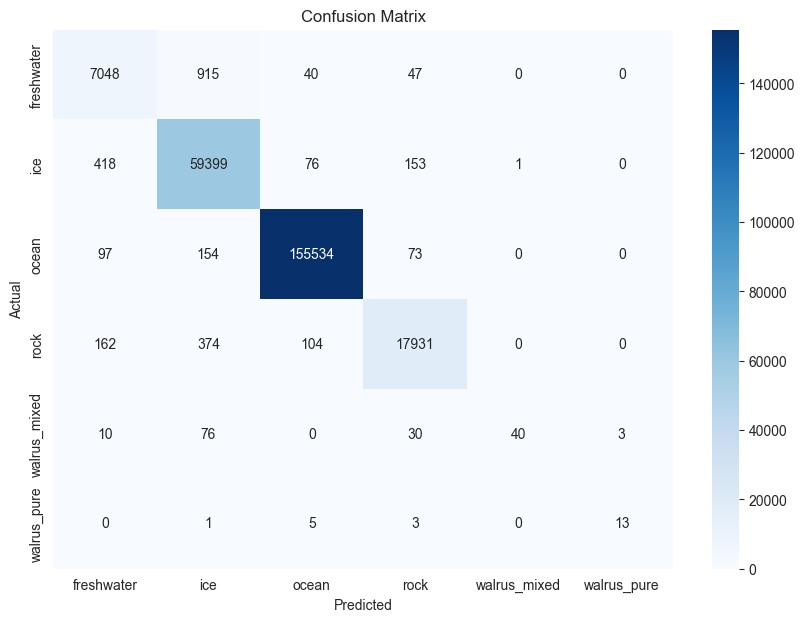

ValueError: multiclass format is not supported

In [37]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Labels present in buch_20230825_image.tif: ['rock', 'walrus_mixed']


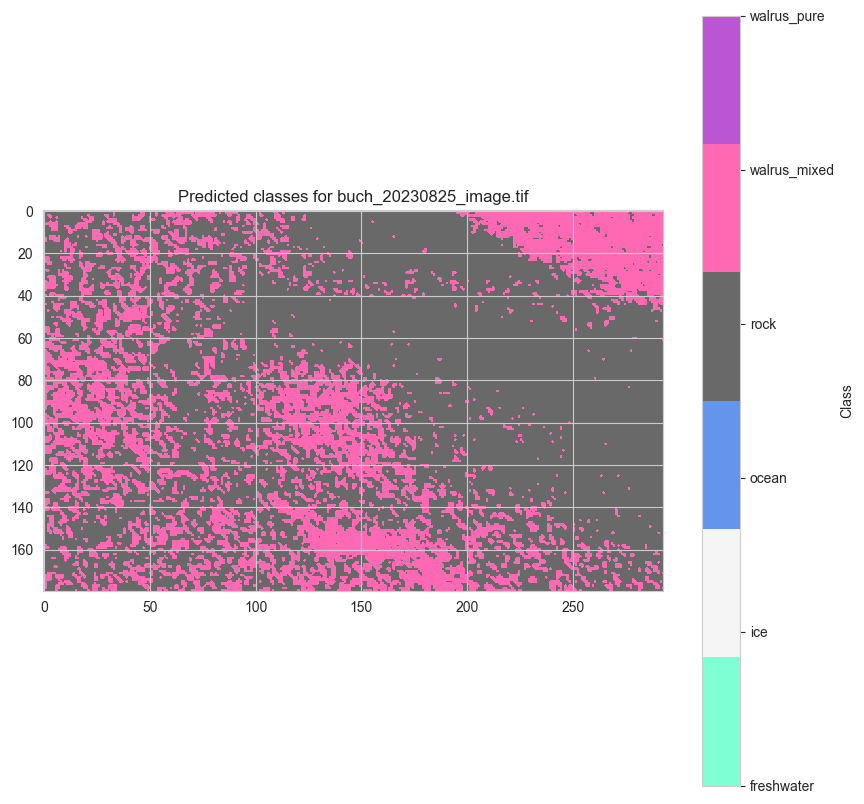

Labels present in buch_20230901_image.tif: ['rock', 'walrus_mixed']


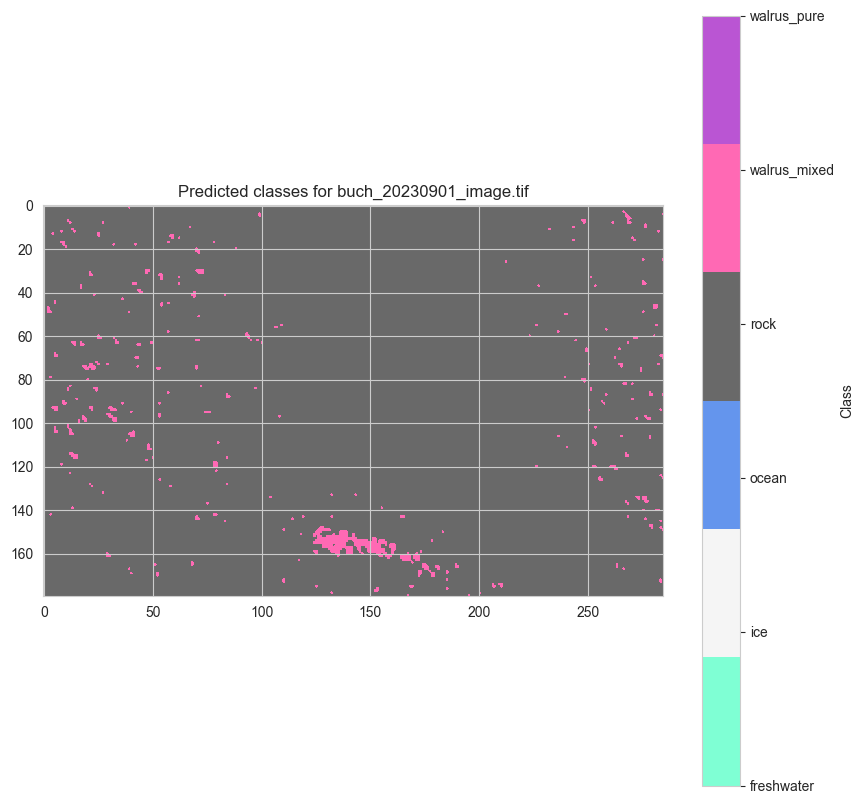

Labels present in pal_20230817_image.tif: ['rock', 'walrus_mixed']


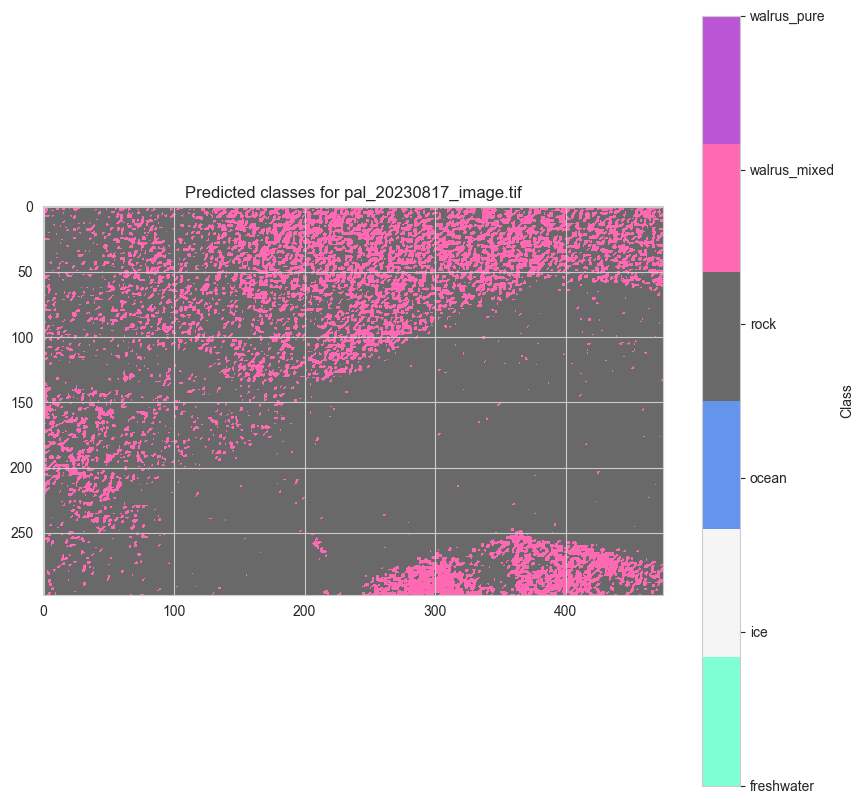

Labels present in pal_20230902_image.tif: ['rock', 'walrus_mixed']


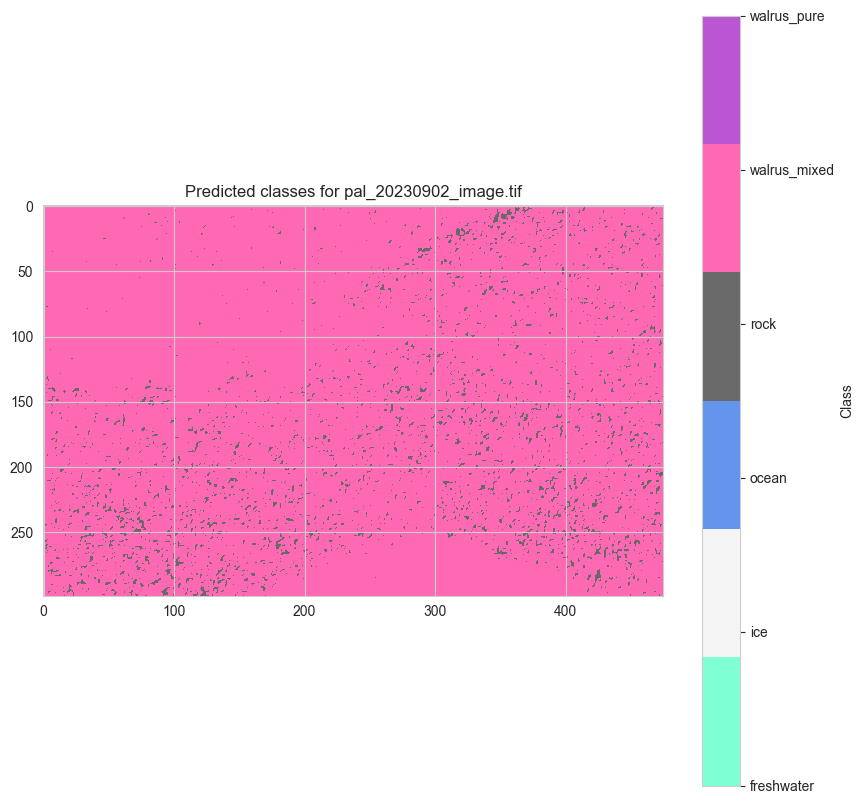

Labels present in sars_20230719_image.tif: ['rock', 'walrus_mixed']


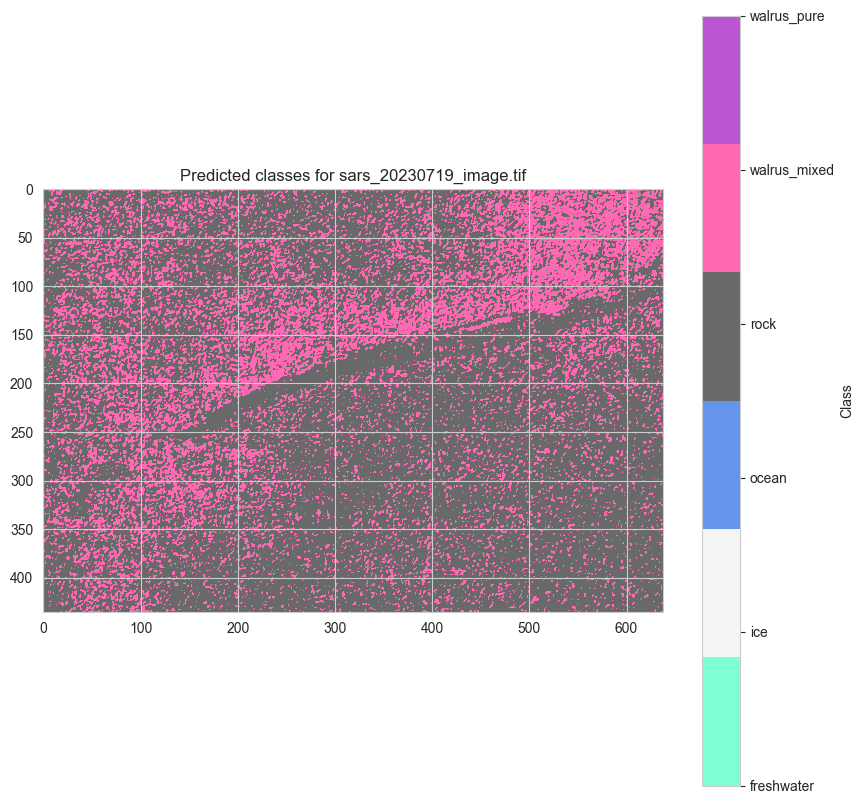

Labels present in sars_20230726_image.tif: ['rock', 'walrus_mixed']


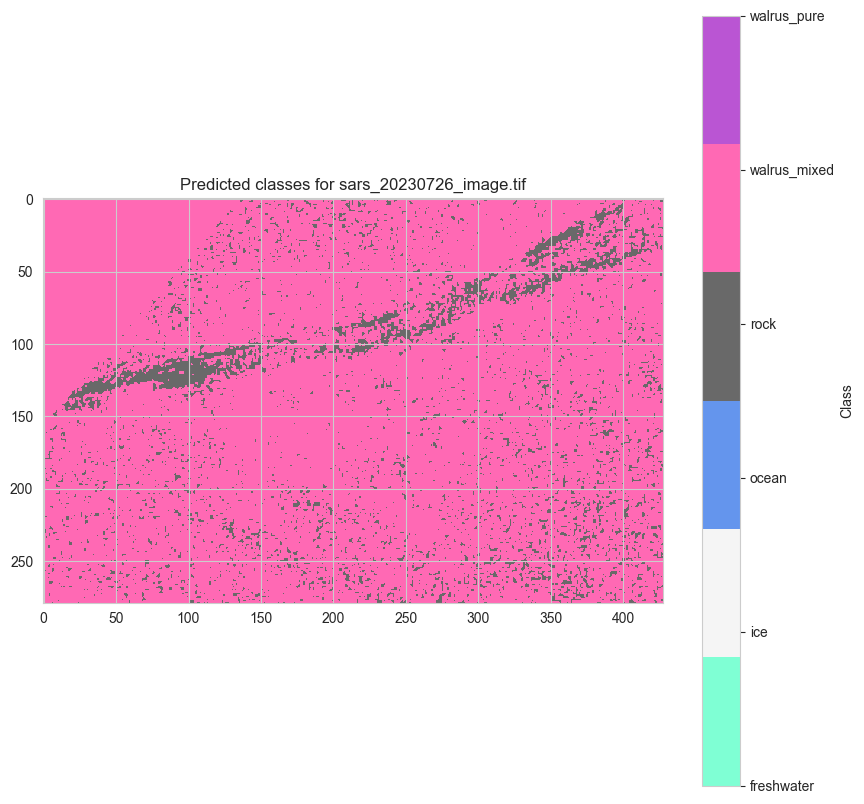

Labels present in sars_20230808_image.tif: ['rock', 'walrus_mixed']


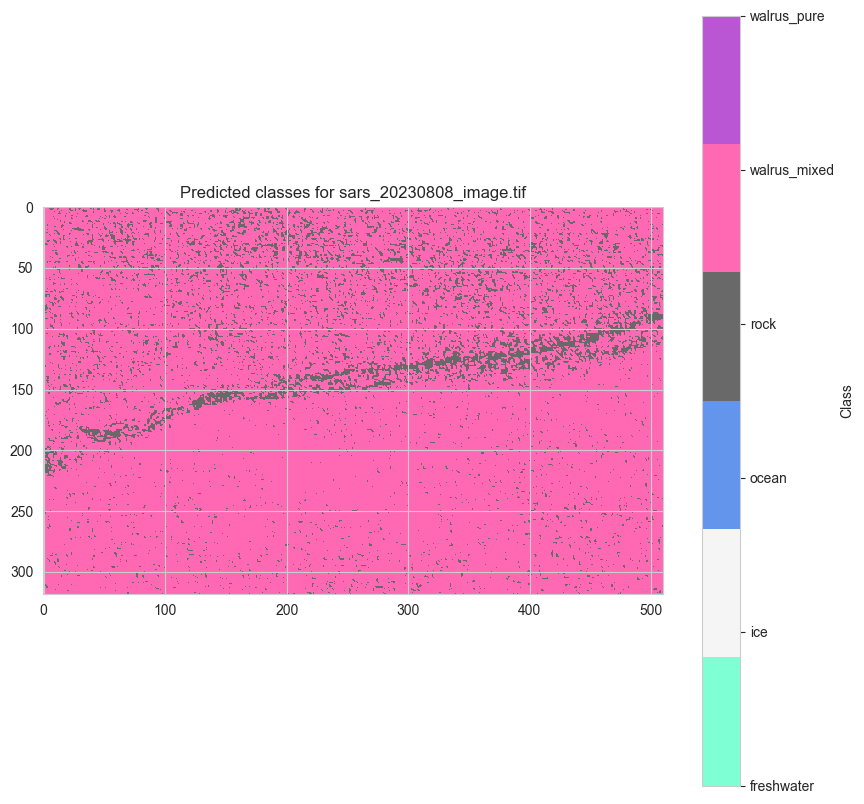

Labels present in tor_20230714_image.tif: ['rock', 'walrus_mixed']


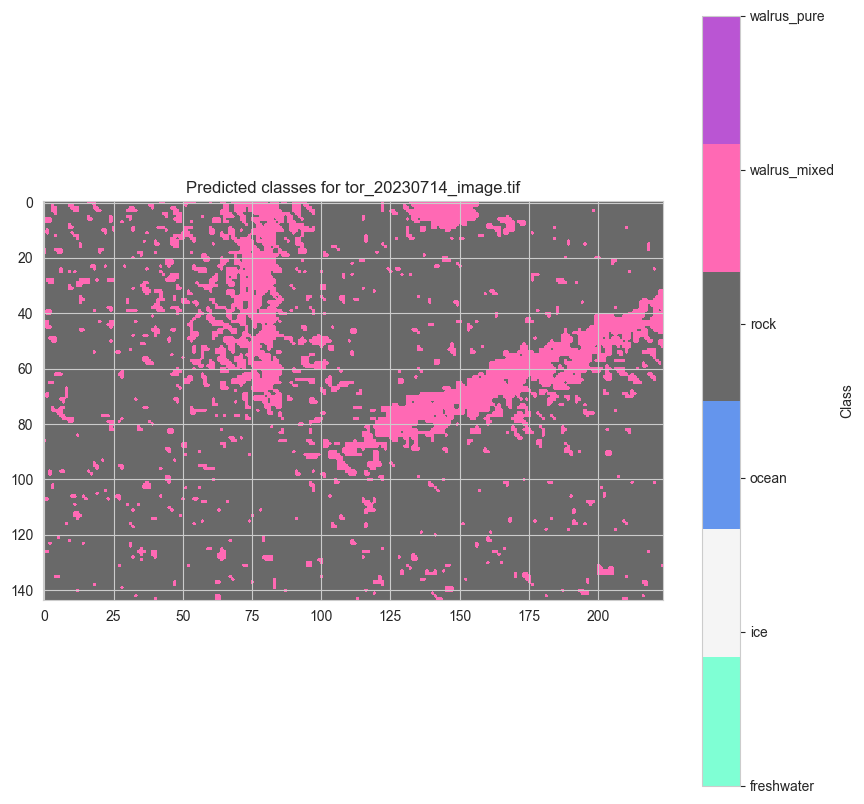

Labels present in tor_20230717_image.tif: ['rock', 'walrus_mixed']


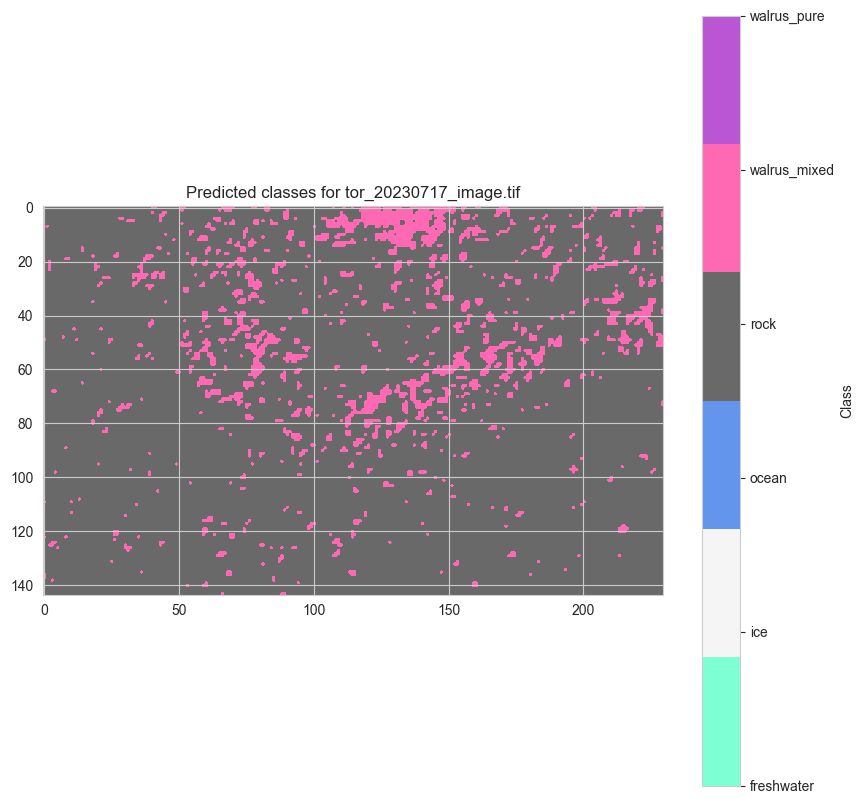

Labels present in tor_20230803_image.tif: ['rock', 'walrus_mixed']


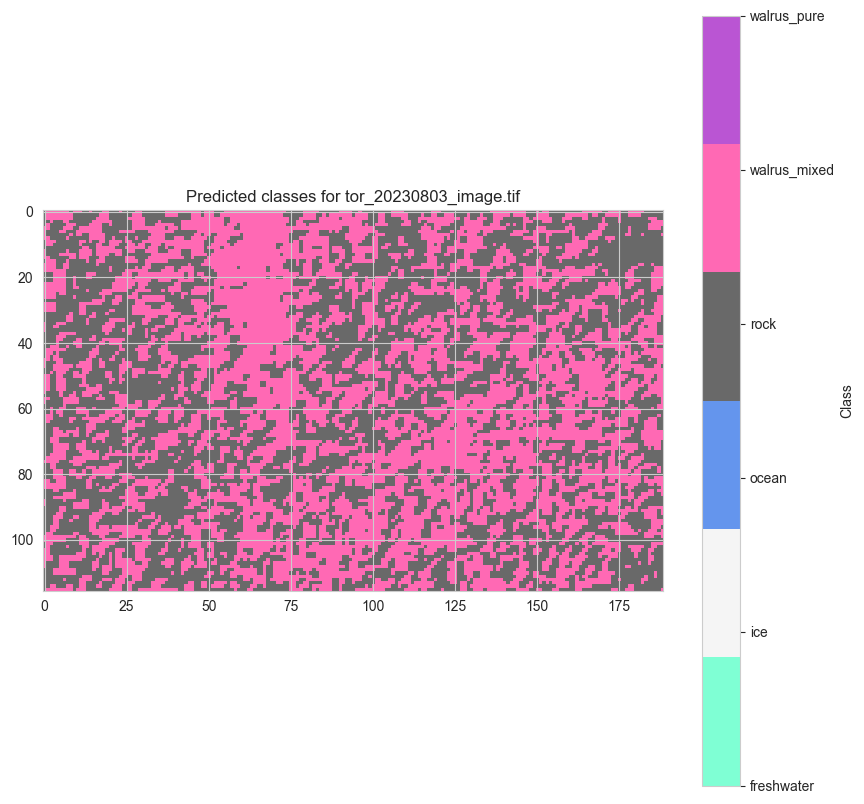

Labels present in tor_20230825_image.tif: ['rock', 'walrus_mixed']


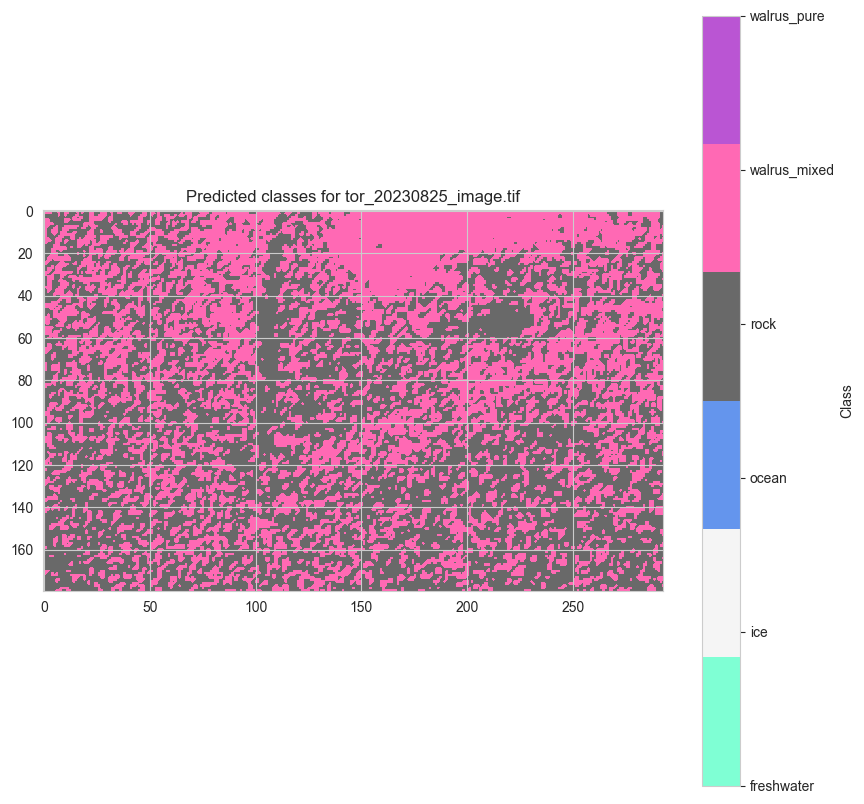

Labels present in tor_20230910_image.tif: ['rock', 'walrus_mixed']


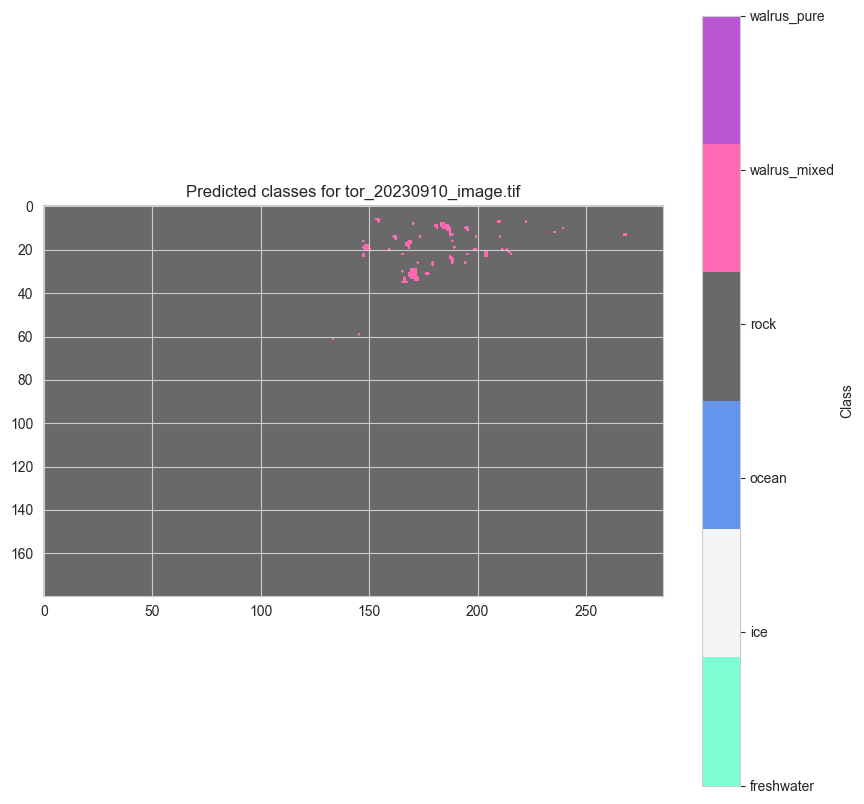

In [38]:
# Function to classify pixels in an image using spectral unmixing
def classify_image(image, endmembers):
    n_bands, n_rows, n_cols = image.shape
    reshaped_image = image.reshape((n_bands, -1)).T  # Shape: (n_pixels, n_bands)
    
    # Normalize the image data
    reshaped_image_normalized = scaler.transform(reshaped_image)

    # Check if the number of bands matches between endmembers and image
    if endmembers.shape[1] != n_bands:
        raise ValueError("Inconsistent number of bands between endmembers and image data.")

    model = LinearRegression(fit_intercept=False)
    model.fit(endmembers, np.eye(endmembers.shape[0]))
    predictions = model.predict(reshaped_image_normalized)

    class_indices = np.argmax(predictions, axis=1)
    classified_image = class_indices.reshape((n_rows, n_cols))
    return classified_image

# Define endmembers based on unique classes
endmembers = {
    'ice': np.mean(features_normalized[encoded_labels == le.transform(['ice'])[0]], axis=0),
    'rock': np.mean(features_normalized[encoded_labels == le.transform(['rock'])[0]], axis=0),
    'freshwater': np.mean(features_normalized[encoded_labels == le.transform(['freshwater'])[0]], axis=0),
    'ocean': np.mean(features_normalized[encoded_labels == le.transform(['ocean'])[0]], axis=0),
    'walrus_pure': np.mean(features_normalized[encoded_labels == le.transform(['walrus_pure'])[0]], axis=0),
    'walrus_mixed': np.mean(features_normalized[encoded_labels == le.transform(['walrus_mixed'])[0]], axis=0),
    'walrus_combined': np.mean(features_normalized[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))], axis=0)
}

endmembers_array = np.array(list(endmembers.values()))

# Function to predict classes for a given image
def predict_image(image_path, model, endmembers):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        
        # Normalize the image data
        image_reshaped_normalized = scaler.transform(image_reshaped)
        
        # Predict with Random Forest
        predictions_rf = model.predict(image_reshaped_normalized)
        
        # Reshape predictions to the image shape
        predictions_rf_reshaped = predictions_rf.reshape((src.height, src.width))
        
        # Apply spectral unmixing
        classified_image = classify_image(image, endmembers)
        
        # Combine predictions from Random Forest and spectral unmixing
        combined_predictions = np.where(classified_image != 0, classified_image, predictions_rf_reshaped)
        
        return combined_predictions

predicted_images = {}

for image_path in unlabeled_image_paths:
    predicted_images[image_path] = predict_image(image_path, model, endmembers_array)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'walrus_combined': 'orchid'
}

# Create a fixed color map based on all possible labels
cmap = plt.cm.colors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [ ]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model, endmembers_array)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (6).

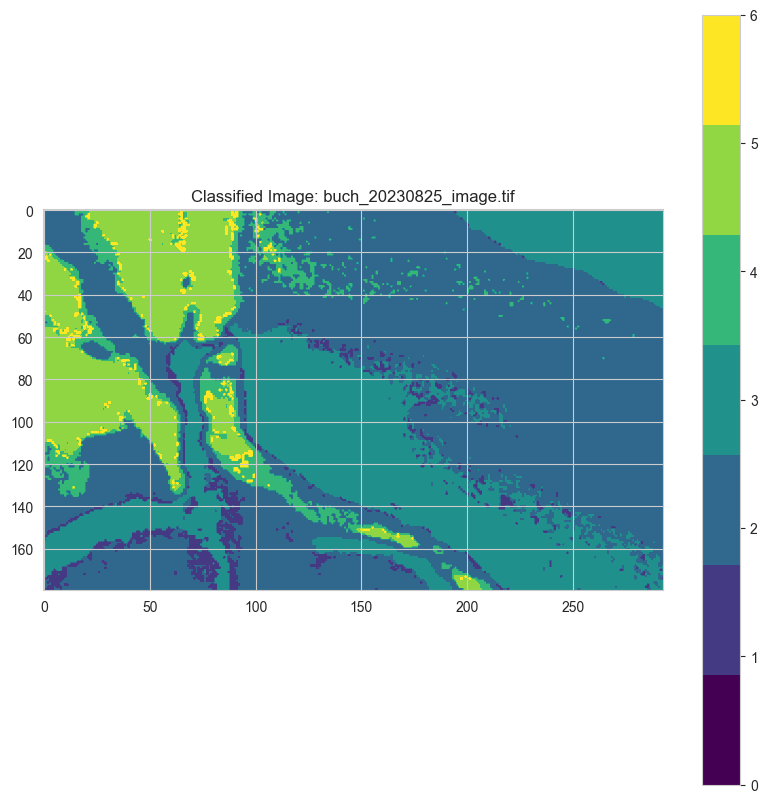

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import rasterio
import glob
import os
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder
import re

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Define endmembers based on unique classes
endmembers = {
    'ice': np.mean(features_normalized[encoded_labels == le.transform(['ice'])[0]], axis=0),
    'rock': np.mean(features_normalized[encoded_labels == le.transform(['rock'])[0]], axis=0),
    'freshwater': np.mean(features_normalized[encoded_labels == le.transform(['freshwater'])[0]], axis=0),
    'ocean': np.mean(features_normalized[encoded_labels == le.transform(['ocean'])[0]], axis=0),
    'walrus_pure': np.mean(features_normalized[encoded_labels == le.transform(['walrus_pure'])[0]], axis=0),
    'walrus_mixed': np.mean(features_normalized[encoded_labels == le.transform(['walrus_mixed'])[0]], axis=0),
    'walrus_combined': np.mean(features_normalized[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))], axis=0)
}

endmembers_array = np.array(list(endmembers.values()))

# Function to classify pixels in an image using spectral unmixing
def classify_image(image, endmembers):
    n_bands, n_rows, n_cols = image.shape
    reshaped_image = image.reshape((n_bands, -1)).T  # Shape: (n_pixels, n_bands)
    
    # Normalize the image data
    reshaped_image_normalized = scaler.transform(reshaped_image)

    # Check if the number of bands matches between endmembers and image
    if endmembers.shape[1] != n_bands:
        raise ValueError("Inconsistent number of bands between endmembers and image data.")

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(endmembers, np.arange(endmembers.shape[0]))
    predictions = model.predict(reshaped_image_normalized)

    classified_image = predictions.reshape((n_rows, n_cols))
    return classified_image

# Classify all unlabeled images
classified_images = {}

for image_path in unlabeled_image_paths:
    with rasterio.open(image_path) as src:
        image = src.read()
    classified_images[image_path] = classify_image(image, endmembers_array)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'walrus_combined': 'orchid'
}

# Plot the classified images
for image_path, classified_image in classified_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Classified Image: {os.path.basename(image_path)}")
    unique_labels = np.unique(classified_image)
    
    # Map labels to their respective colors
    color_map = [label_colors[le.inverse_transform([label])[0]] if label in le.classes_ else 'black' for label in unique_labels]
    
    plt.imshow(classified_image, cmap=plt.get_cmap('viridis', len(label_colors)), vmin=0, vmax=len(label_colors) - 1)
    cbar = plt.colorbar(ticks=range(len(label_colors)))
    cbar.ax.set_yticklabels([le.inverse_transform([label])[0] if label in le.classes_ else 'unknown' for label in unique_labels])
    plt.show()


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


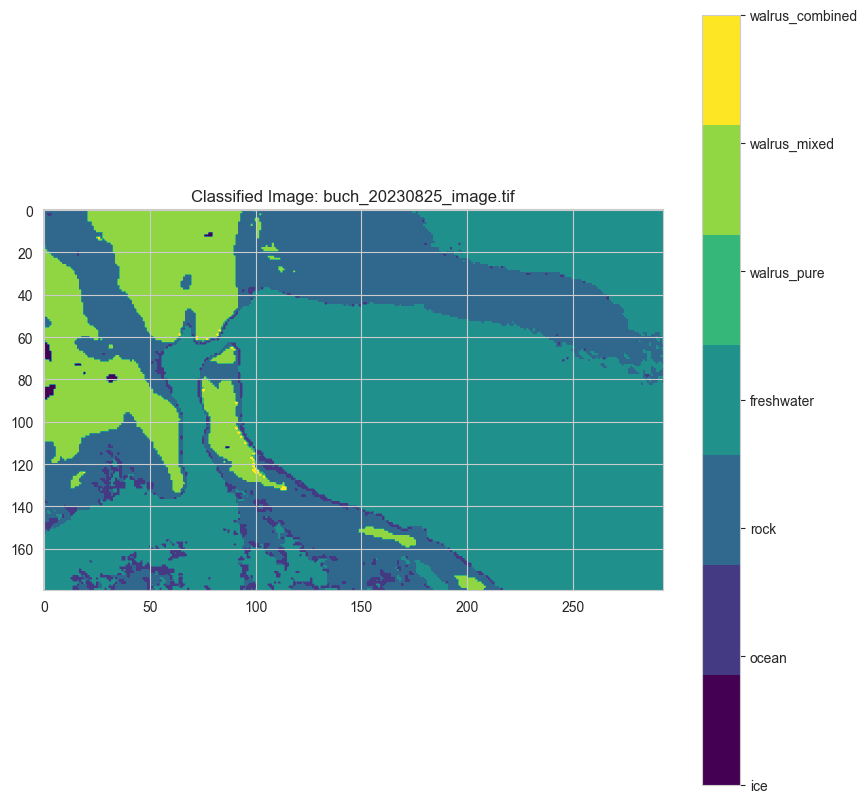

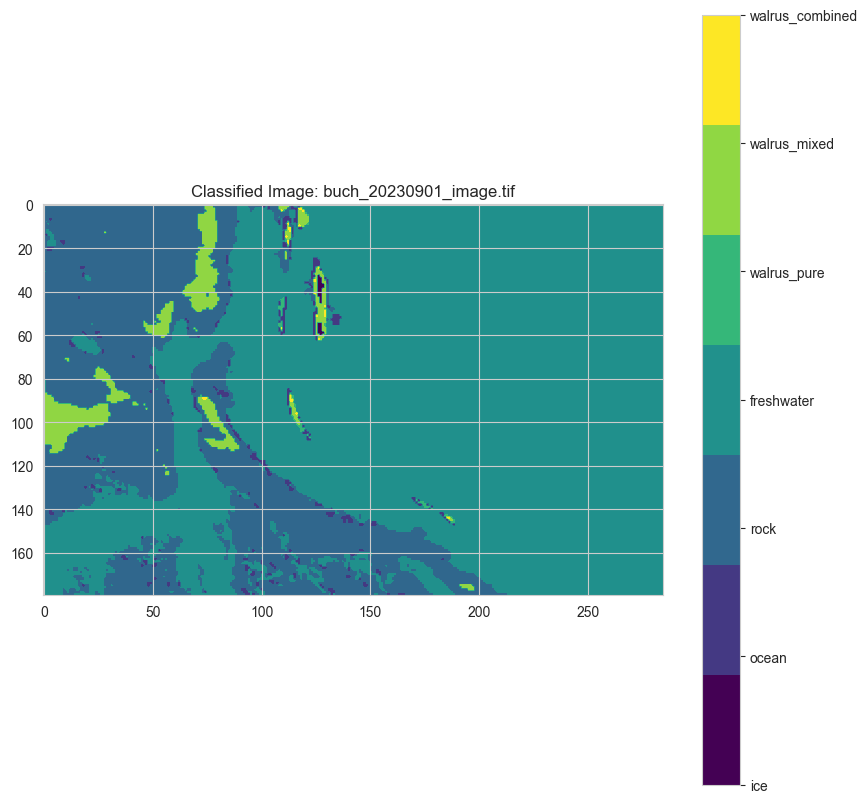

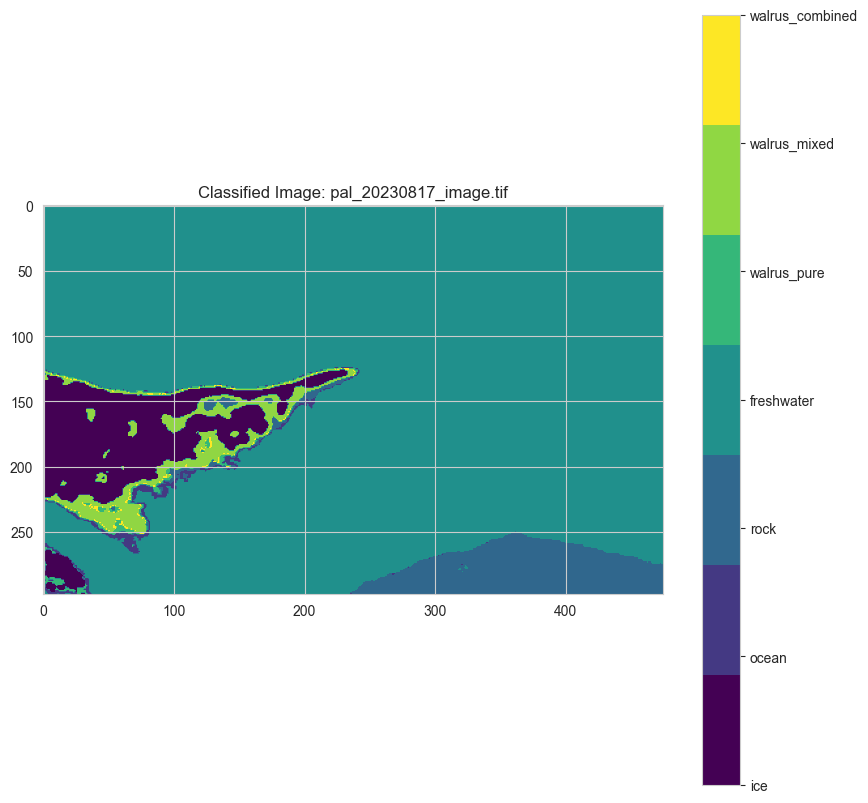

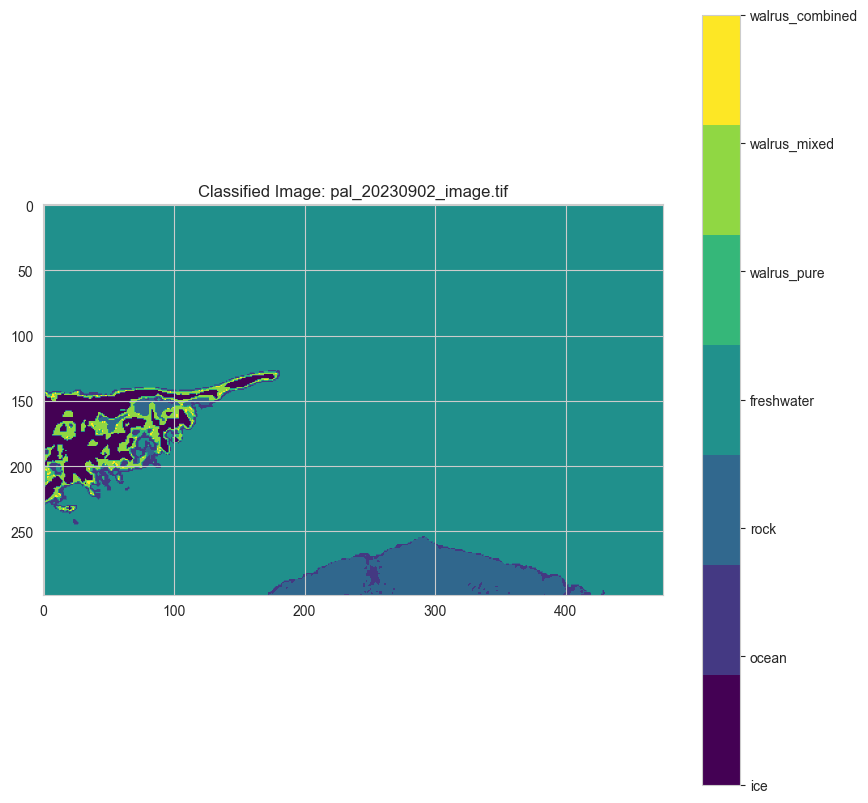

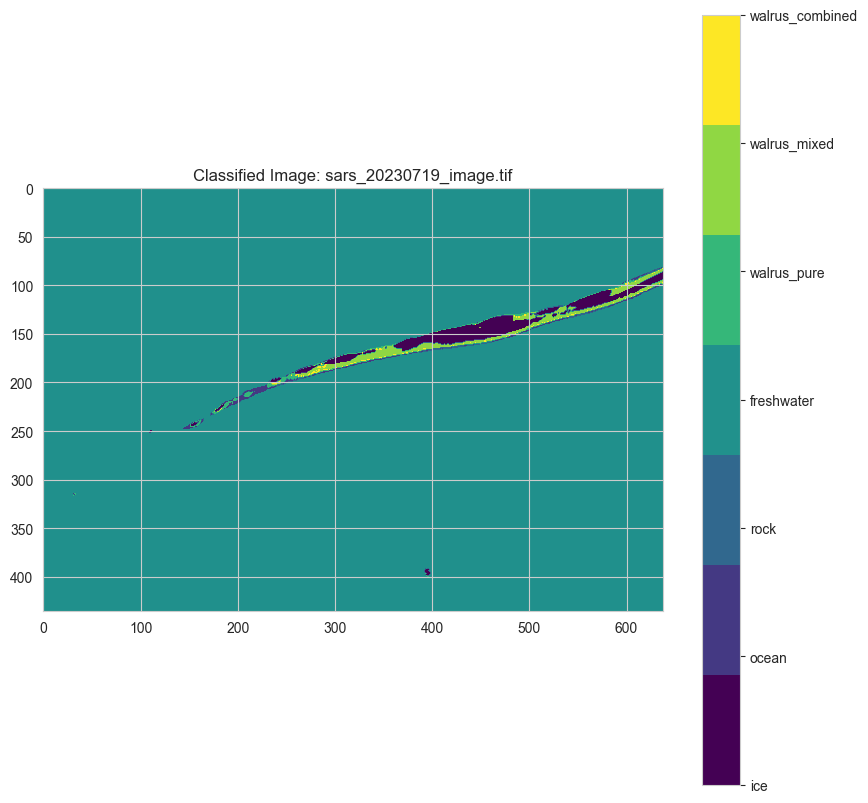

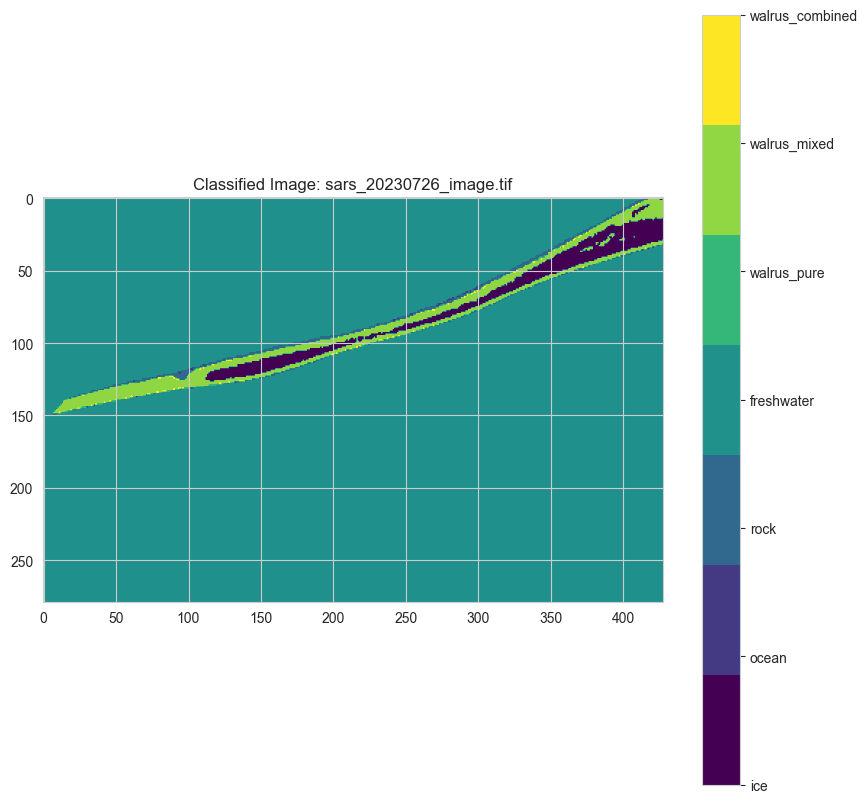

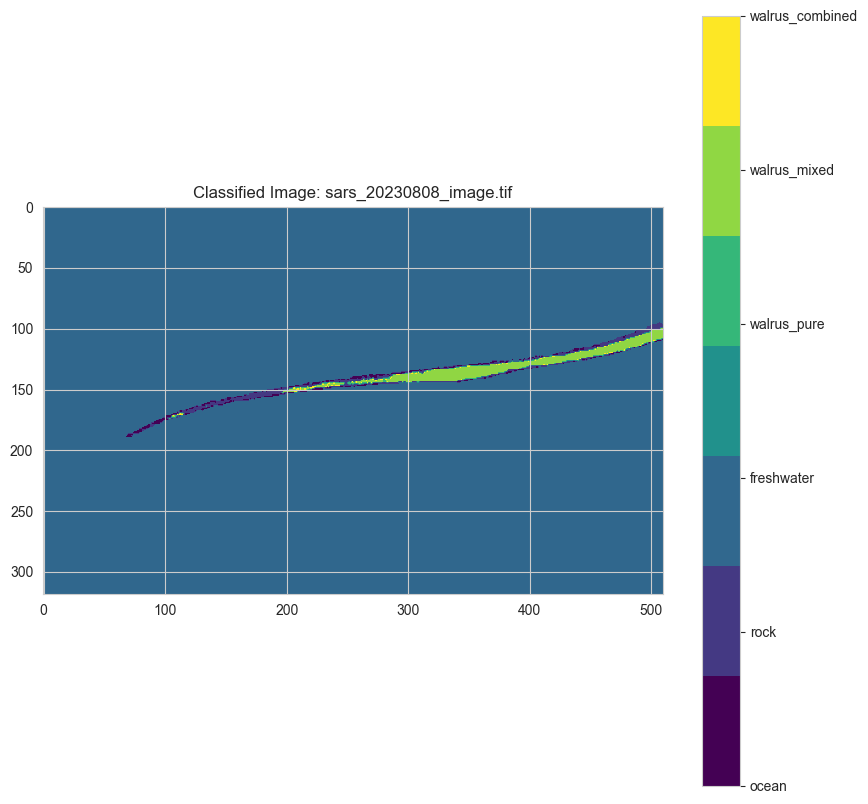

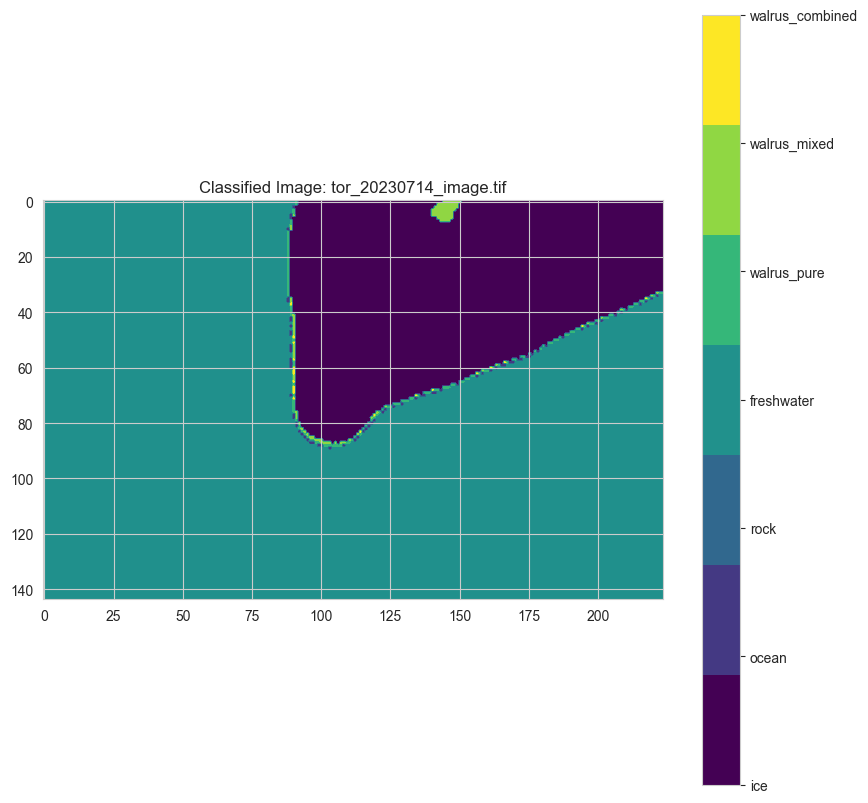

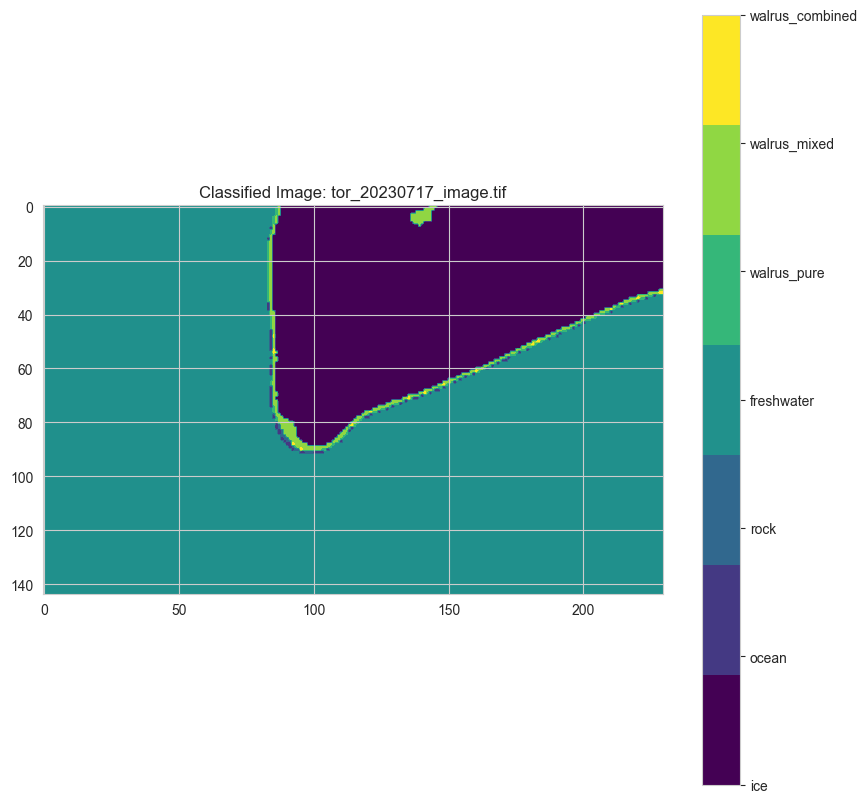

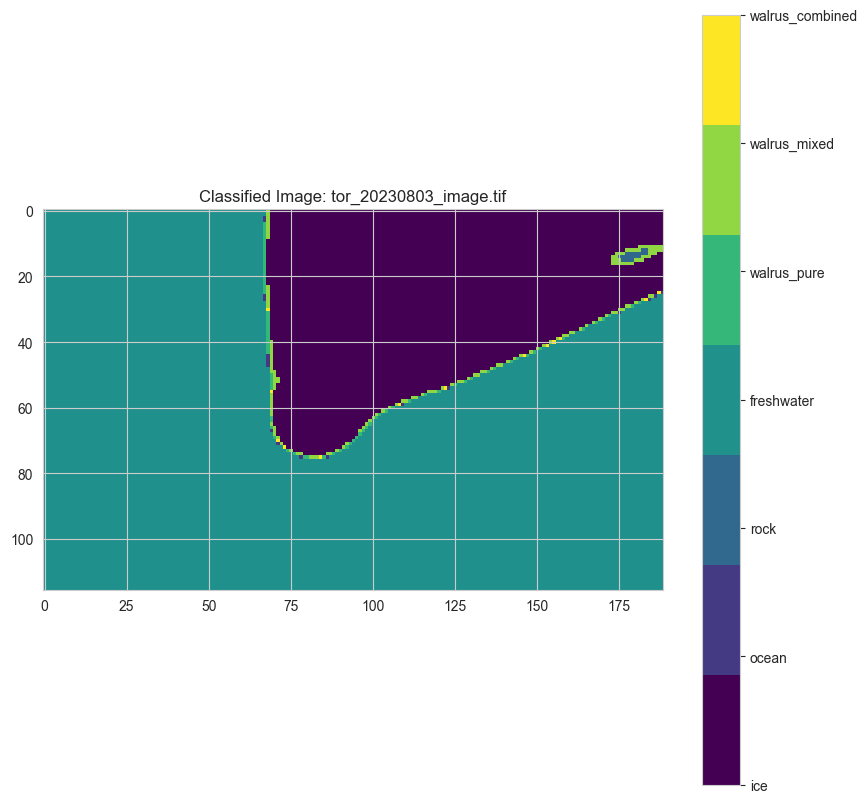

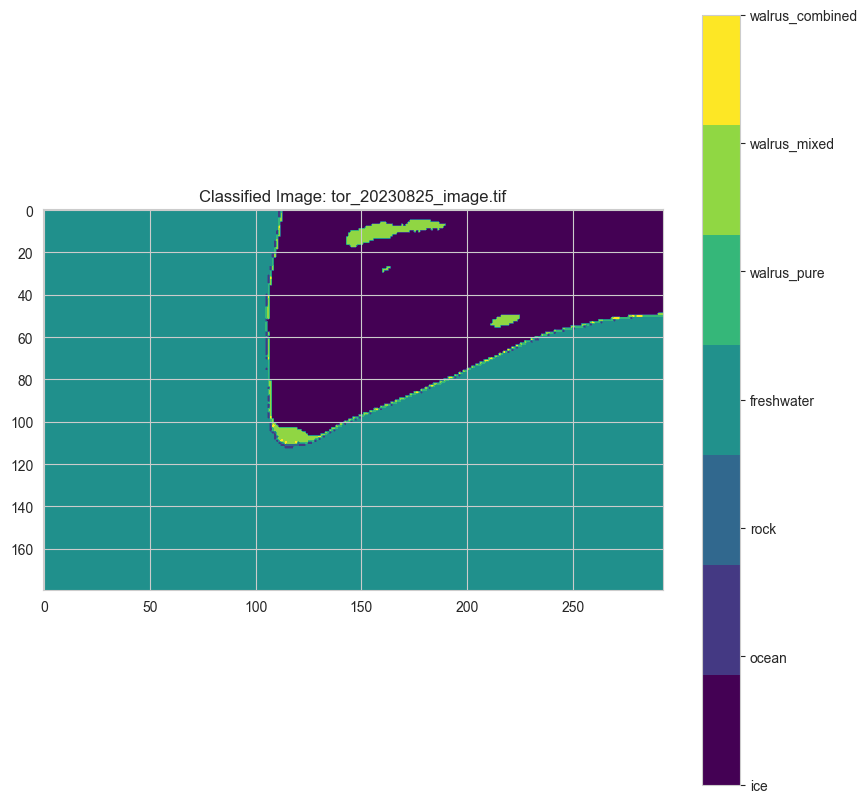

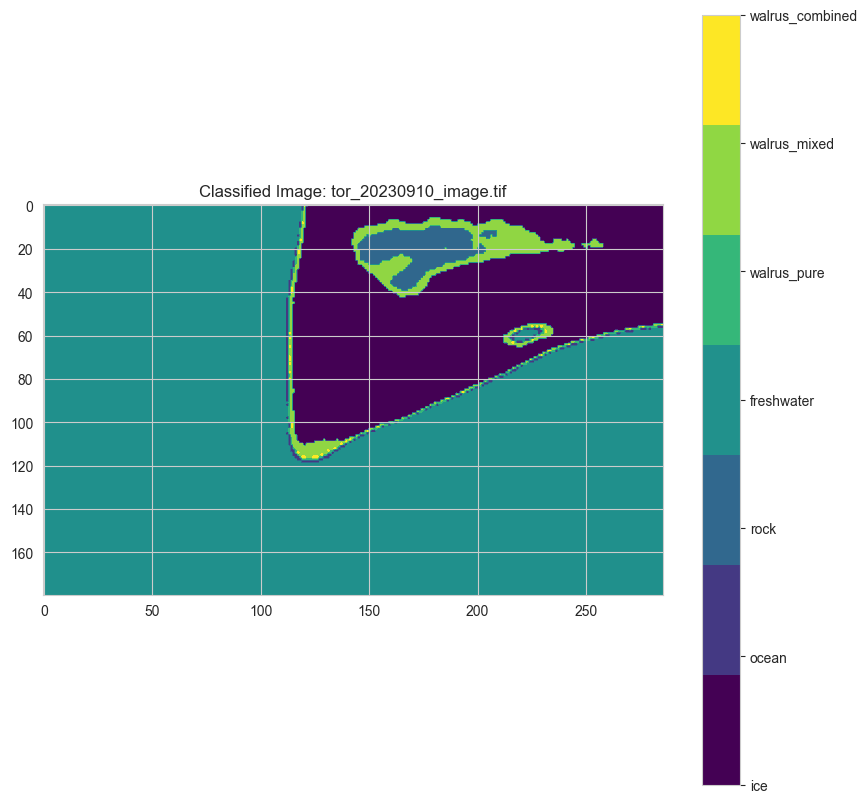

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import rasterio
import glob
import os
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Define endmembers based on unique classes
endmembers = {
    'ice': np.mean(features_normalized[encoded_labels == le.transform(['ice'])[0]], axis=0),
    'rock': np.mean(features_normalized[encoded_labels == le.transform(['rock'])[0]], axis=0),
    'freshwater': np.mean(features_normalized[encoded_labels == le.transform(['freshwater'])[0]], axis=0),
    'ocean': np.mean(features_normalized[encoded_labels == le.transform(['ocean'])[0]], axis=0),
    'walrus_pure': np.mean(features_normalized[encoded_labels == le.transform(['walrus_pure'])[0]], axis=0),
    'walrus_mixed': np.mean(features_normalized[encoded_labels == le.transform(['walrus_mixed'])[0]], axis=0),
    'walrus_combined': np.mean(features_normalized[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))], axis=0)
}

endmembers_array = np.array(list(endmembers.values()))

# Function to classify pixels in an image using spectral unmixing
def classify_image(image, endmembers):
    n_bands, n_rows, n_cols = image.shape
    reshaped_image = image.reshape((n_bands, -1)).T  # Shape: (n_pixels, n_bands)
    
    # Normalize the image data
    reshaped_image_normalized = scaler.transform(reshaped_image)

    # Check if the number of bands matches between endmembers and image
    if endmembers.shape[1] != n_bands:
        raise ValueError("Inconsistent number of bands between endmembers and image data.")

    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    model.fit(endmembers, np.arange(endmembers.shape[0]))
    predictions = model.predict(reshaped_image_normalized)

    classified_image = predictions.reshape((n_rows, n_cols))
    return classified_image

# Classify all unlabeled images
classified_images = {}

for image_path in unlabeled_image_paths:
    with rasterio.open(image_path) as src:
        image = src.read()
    classified_images[image_path] = classify_image(image, endmembers_array)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'walrus_combined': 'orchid'
}

# Plot the classified images
for image_path, classified_image in classified_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Classified Image: {os.path.basename(image_path)}")
    plt.imshow(classified_image, cmap=plt.get_cmap('viridis', len(label_colors)))
    plt.colorbar(ticks=range(len(label_colors)), format=plt.FuncFormatter(lambda val, loc: list(label_colors.keys())[val]))
    plt.show()


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import rasterio
import glob
import os
import geopandas as gpd
from rasterio.features import geometry_mask
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Define endmembers based on unique classes
endmembers = {
    'ice': np.mean(features[encoded_labels == le.transform(['ice'])[0]], axis=0),
    'rock': np.mean(features[encoded_labels == le.transform(['rock'])[0]], axis=0),
    'freshwater': np.mean(features[encoded_labels == le.transform(['freshwater'])[0]], axis=0),
    'ocean': np.mean(features[encoded_labels == le.transform(['ocean'])[0]], axis=0),
    'walrus_pure': np.mean(features[encoded_labels == le.transform(['walrus_pure'])[0]], axis=0),
    'walrus_mixed': np.mean(features[encoded_labels == le.transform(['walrus_mixed'])[0]], axis=0),
    'walrus_combined': np.mean(features[np.isin(encoded_labels, le.transform(['walrus_pure', 'walrus_mixed']))], axis=0)
}

endmembers_array = np.array(list(endmembers.values()))

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


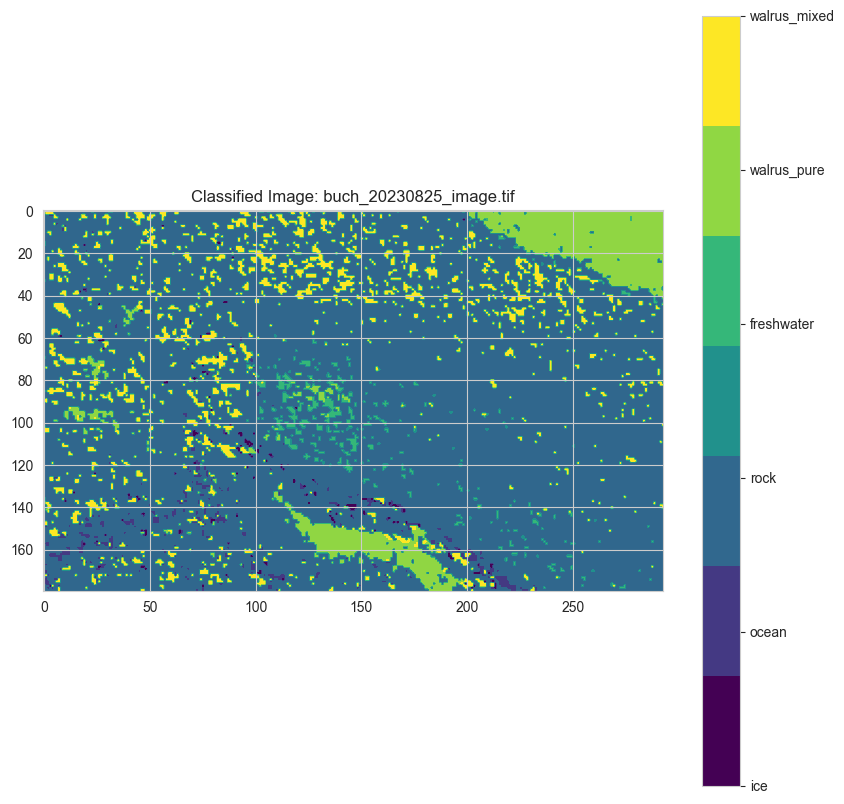

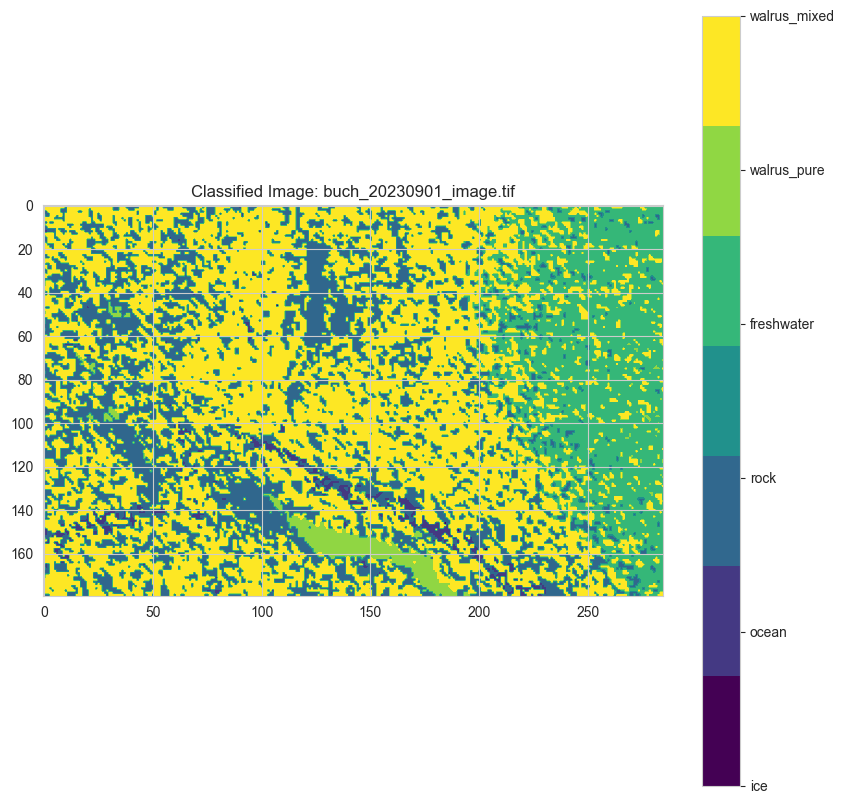

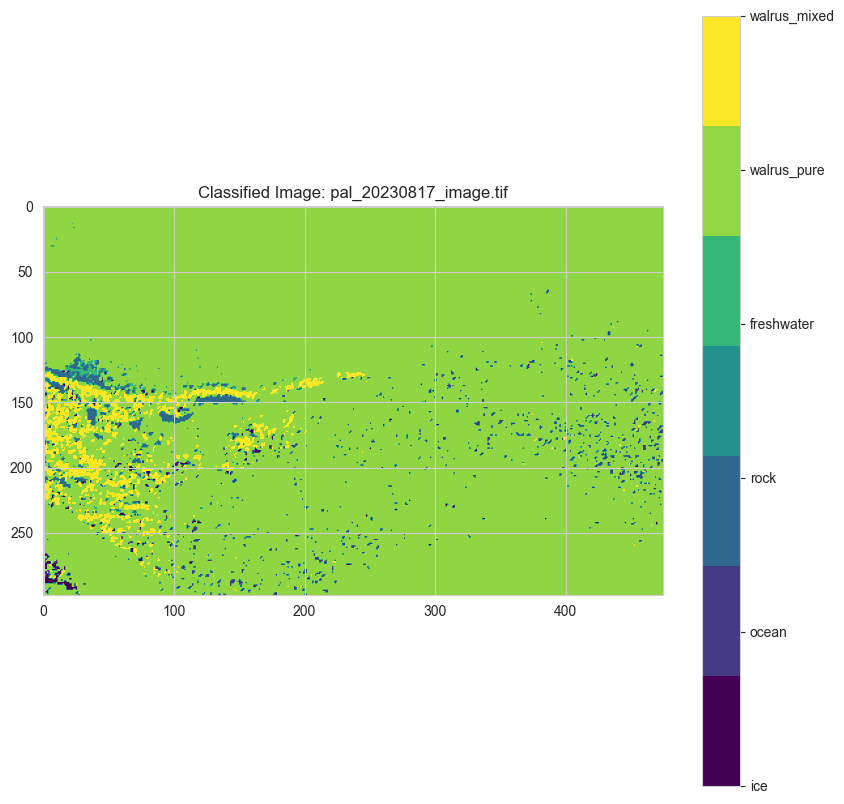

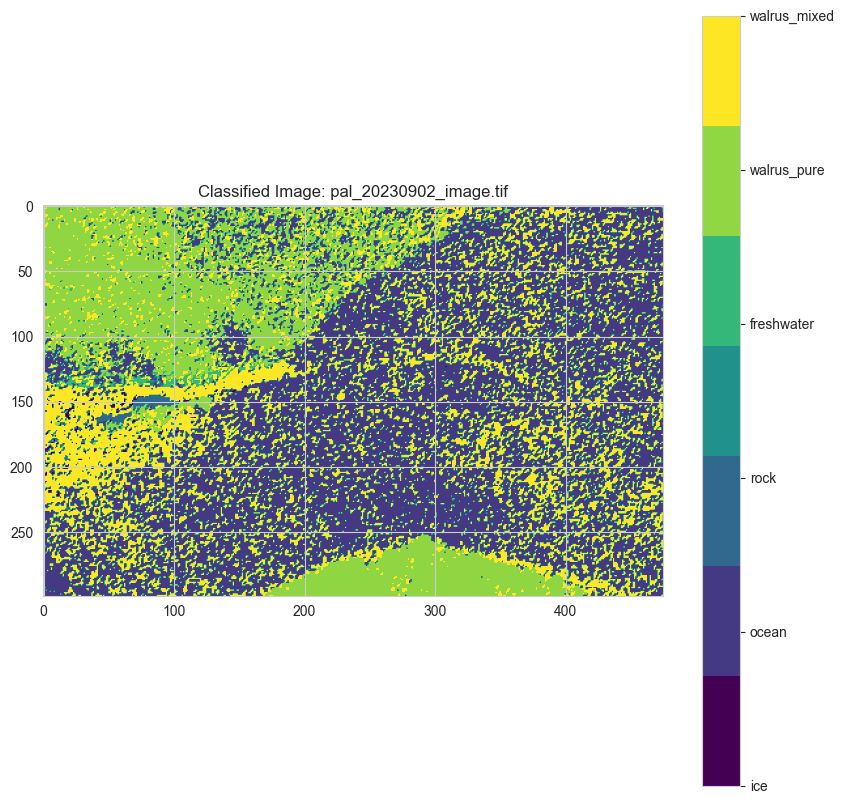

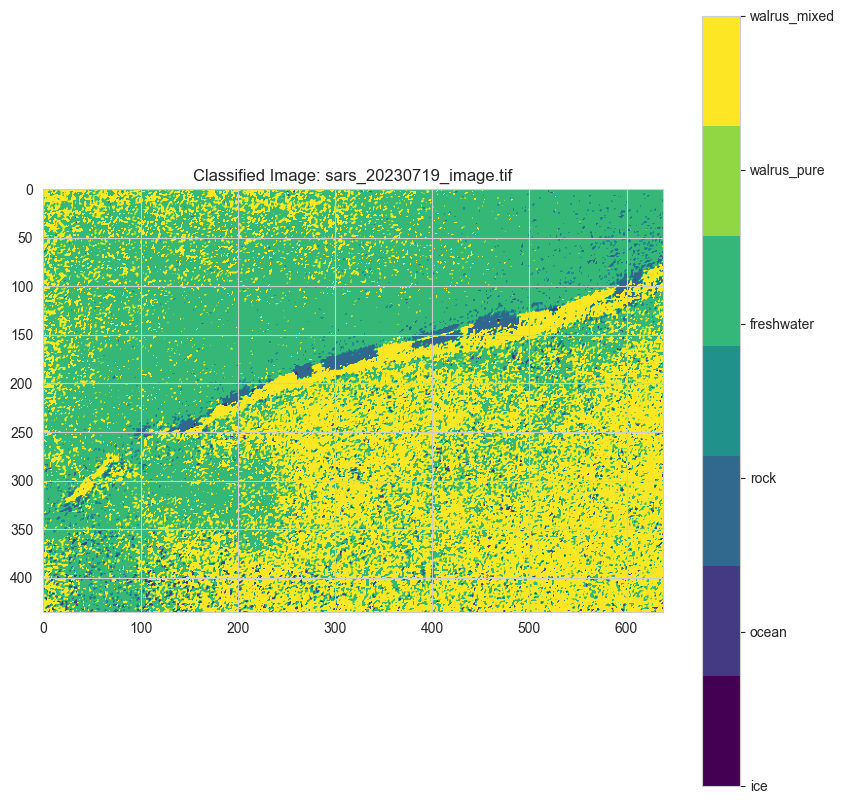

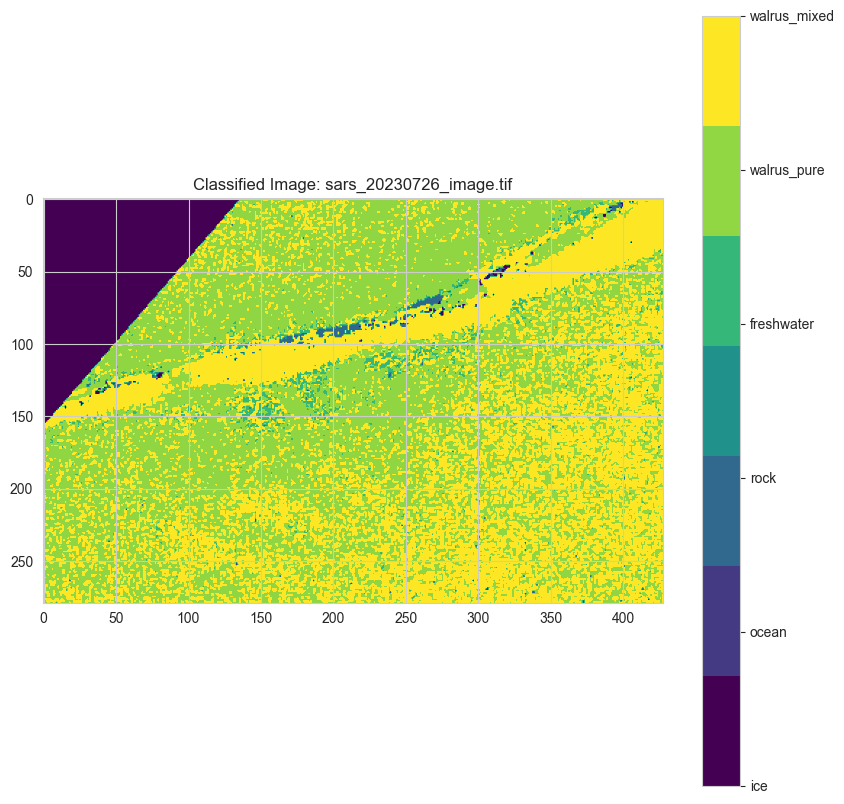

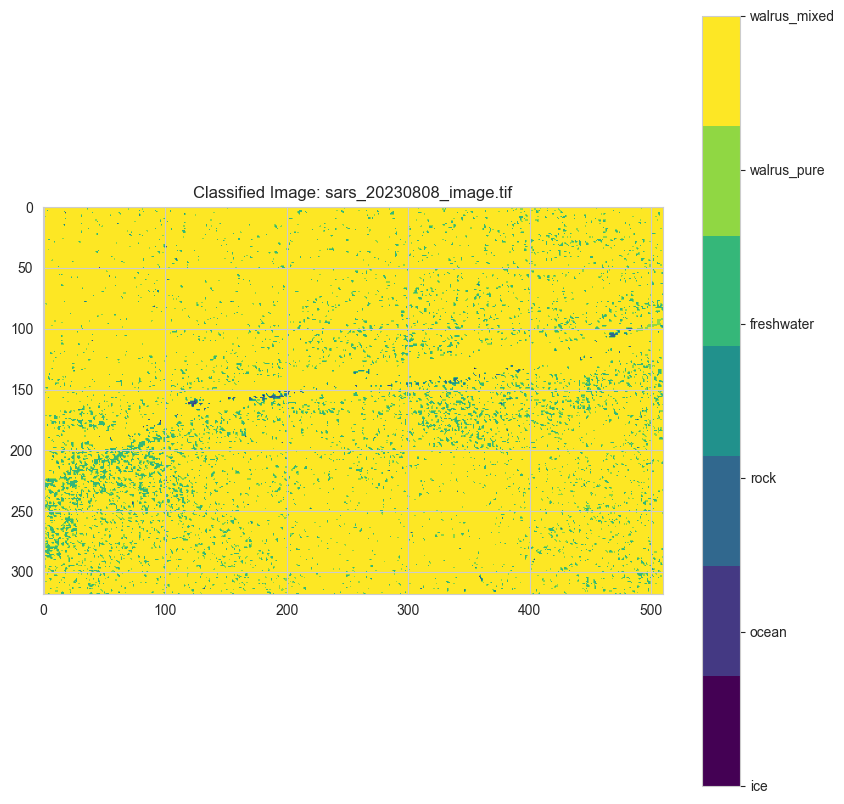

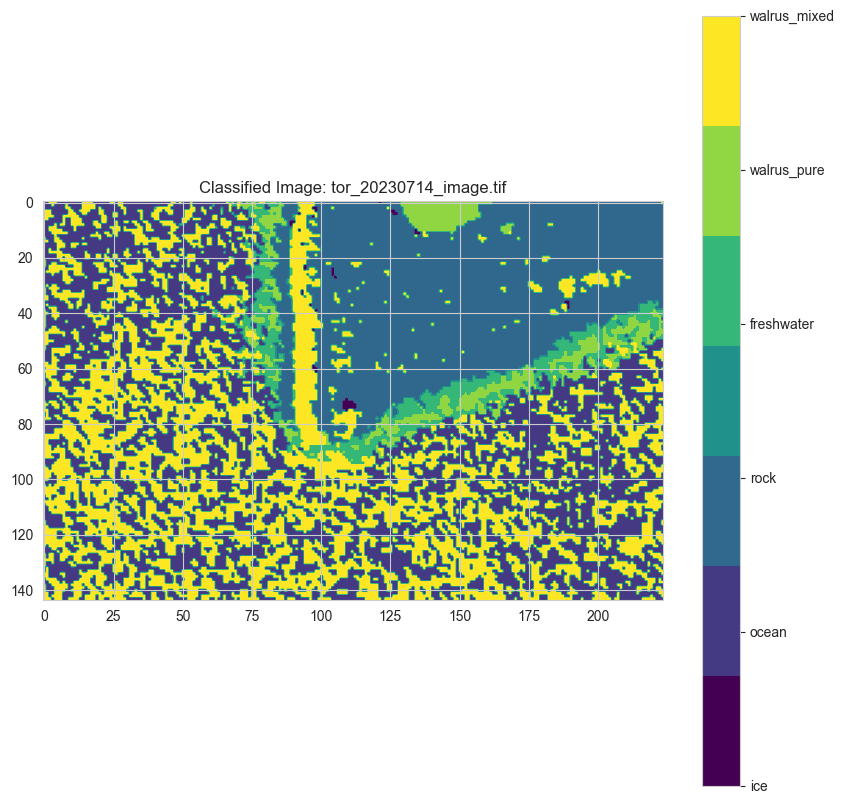

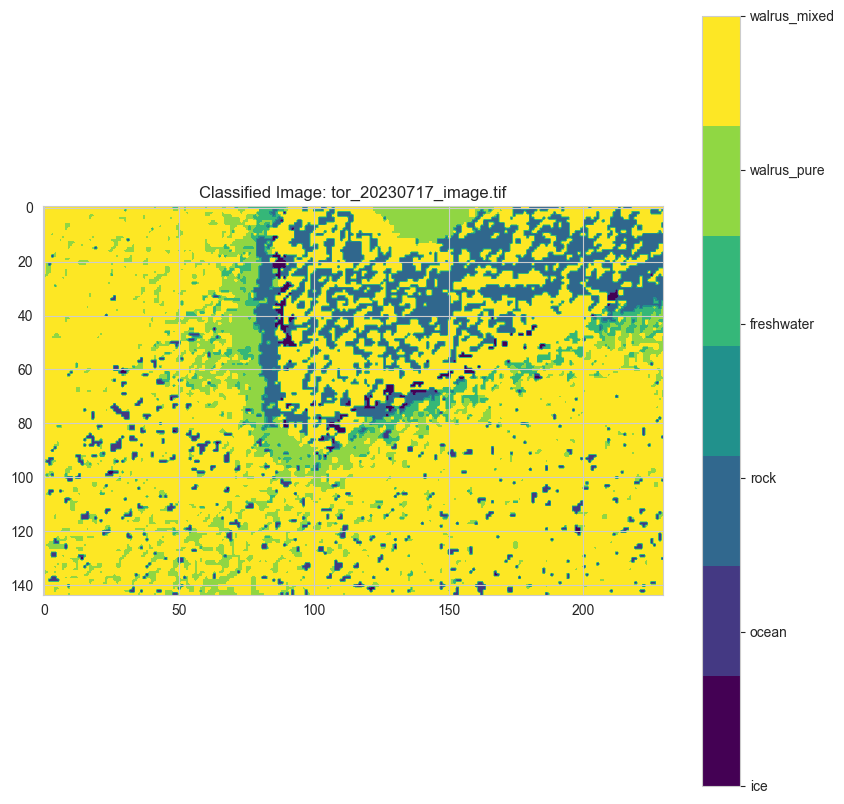

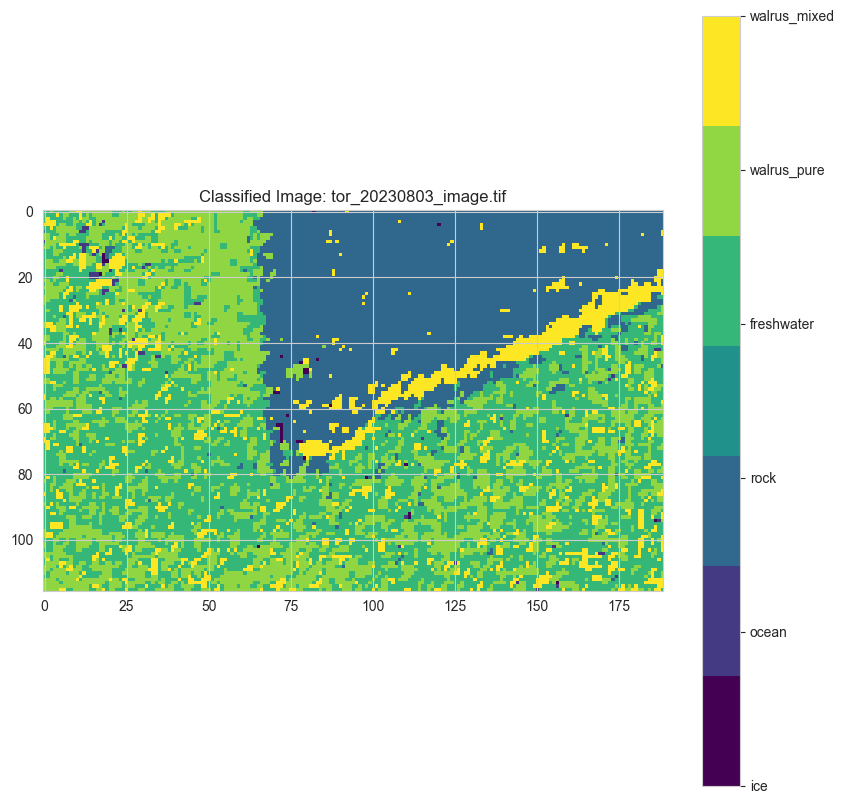

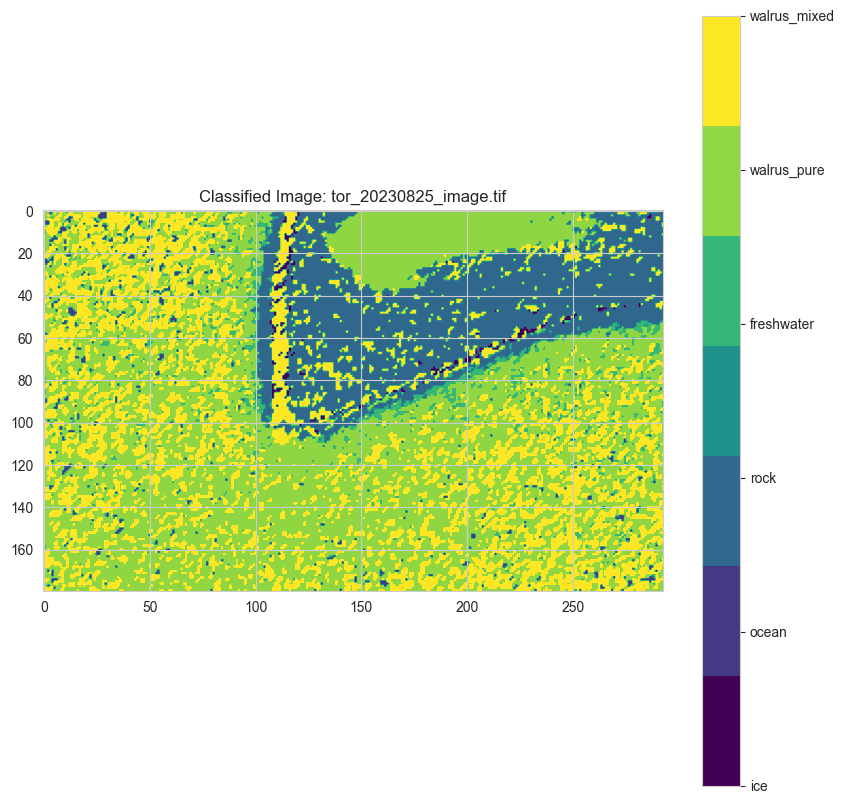

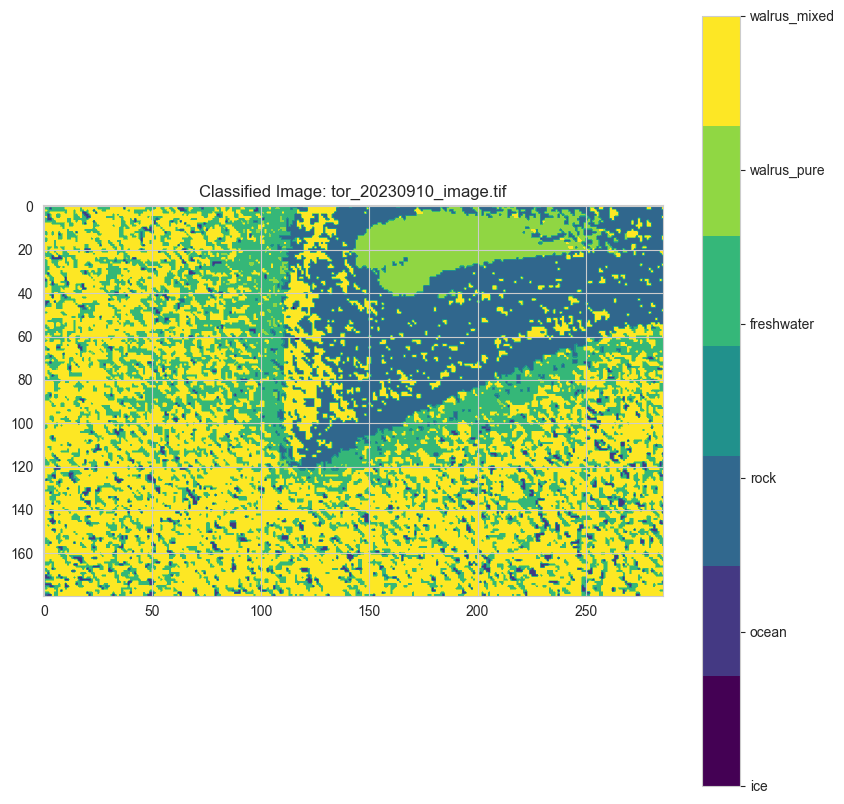

In [31]:
# Function to classify pixels in an image using spectral unmixing
def classify_image(image, endmembers):
    n_bands, n_rows, n_cols = image.shape
    reshaped_image = image.reshape((n_bands, -1)).T  # Shape: (n_pixels, n_bands)

    # Check if the number of bands matches between endmembers and image
    if endmembers.shape[1] != n_bands:
        raise ValueError("Inconsistent number of bands between endmembers and image data.")

    model = LinearRegression(fit_intercept=False)
    model.fit(endmembers, np.eye(endmembers.shape[0]))
    predictions = model.predict(reshaped_image)

    class_indices = np.argmax(predictions, axis=1)
    classified_image = class_indices.reshape((n_rows, n_cols))
    return classified_image

# Classify all unlabeled images
classified_images = {}

for image_path in unlabeled_image_paths:
    with rasterio.open(image_path) as src:
        image = src.read()
    classified_images[image_path] = classify_image(image, endmembers_array)

# Define a color map for the labels
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink',
    'walrus_combined': 'orchid'
}

# Plot the classified images
for image_path, classified_image in classified_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Classified Image: {os.path.basename(image_path)}")
    plt.imshow(classified_image, cmap=plt.get_cmap('viridis', len(label_colors)))
    plt.colorbar(ticks=range(len(label_colors)), format=plt.FuncFormatter(lambda val, loc: list(label_colors.keys())[val]))
    plt.show()